In [1]:
%%writefile serre.py

import numpy as np
import matplotlib.pyplot as plt
import nswe


Overwriting serre.py


$\newcommand{\th}{\tilde{h}}$
$\newcommand{\tu}{\tilde{u}}$

$\newcommand{\lh}{\overline{h}}$
$\newcommand{\lu}{\overline{u}}$

$\newcommand{\Atwo}[2]{\left( \begin{array}{c} #1 \\ #2  \end{array} \right)}$


# Numerical resolution of the Serre equations

## The model

The Serre equations are a model to describe higly nonlinear waves propagating in shallow waters. Considering a horizontal bottom, these equations are written as

$h_t + (hu)_x = 0$

$u_t + uu_x + gh_x - \frac{1}{3h}\left(h^3 \left( u_{xt} + uu_{xx} - (u_x)^2  \right) \right)_x = 0$

where $u = u(x,t)$, $h = h(x,t)$ and $g$ are, respectively, the depth-averaged horizontal velocity of the fluid, the water depth and the gravity acceleration.


## Discretization

As done previously for the numerical resolution of the KdV and the BBM equations, the Serre equations will be numerically solved using a splitting method, in which the system of equations will be decomposed in two : the first one will contain the advection terms, and the second one, all the high-order derivative terms.

Therefore, the numerical resolution will consist in solve, in each time step $[t_n, t_{n+1}]$, the following problem :

\begin{equation}
\begin{cases}
\th_t + \left(\th\tu\right)_x = 0 \\
\tu_t + \tu\tu_x + g\th_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\th,\tu)(x,t_n) = (h,u)(x,t_n)
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
\lh_t   = 0 \\
\lu_t - \frac{1}{3\lh}\left(\lh^3 \left( \lu_{xt} + \lu\lu_{xx} - (\lu_x)^2  \right) \right)_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\lh,\lu)(x,t_n) = (\th,\tu)(x,t_{n+1})
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
(h,u)(x,t_{n+1}) = (\lh,\lu)(x,t_{n+1})
\end{cases}
\end{equation}

In the following descriptions of the resolution of the two schemes, the tilde and the overbar will be omitted for the sake of clarity.

### First system of equations

In order to solve the advection system with the Roe solver (an approximation of the Riemman solver), one must write it in the classical form $U_t +  F(U)_x = 0$, where $U$ is the vector of unknowns and $F$ is a flux function.

We have that

$(hu)_t = uh_t + hu_t = -u(hu)_x - h\left(uu_x + gh_x\right) = -u\left (h_xu + 2hu_x \right) - ghh_x = -\left(hu^2\right)_x - \frac{1}{2}g\left(h^2\right)_x = - \left(hu^2 -  \frac{1}{2}gh^2 \right)_x$

Therefore, the system can be rewritten as

\begin{equation}
\begin{cases}
h_t + \left(hu \right)_x = 0 \\
\left(hu \right)_t + \left(hu^2 -  \frac{1}{2}gh^2 \right)_x = 0
\end{cases}
\end{equation}

and we will solve it for the unknowns $U = \Atwo{h}{hu}$, with the flux function $F \Atwo{h}{hu} = \Atwo{hu}{hu^2 -  \frac{1}{2}gh^2} $. The time step is discretized using a 4th order Runge-Kutta scheme.


### Second system of equations

In the second system of the splitted Serre equations, the water depth $h$ is constant in time, and therefore only the velocity $u$ must be updated. Separating the terms containing time derivatives, the second equation of thi suystem can be rewritten as 

$\left( u - hh_xu_x - \frac{1}{3}h^2u_{xx} \right)_t  - \frac{1}{3h}\left(h^3 \left( uu_{xx} - (u_x)^2  \right) \right)_x = 0 $

This equation will be solved using an explicit Finite Difference scheme. Defining

$g_1 = h^3 \left( uu_{xx} - (u_x)^2 \right)$

$g_2 = u - h h_x u_x - \frac{1}{3}h^2 u_{xx}$

where the derivatives are evalueated using appropriate finite difference approximations.

With this notation, using an one-step forward time discretization, one gets

$(g_2)_i^{n+1} = (g_2)_i^n + \frac{\Delta t}{3h_i^n} \left(\left( g_1 \right)_x\right)_i^n = G_i^n$

where the superscript and the subscript denotes respectively the time step and the spatial position.

Using 2nd order centered approximation for the spatial derivatives in $(g_2)_i^{n+1}$, one gets the following tridiagonal linear system :

$\left( \frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i-1}^{n+1} + 
 \left( 1 + \frac{2(h_i^n)^2}{3\Delta x^2} \right)u_{i}^{n+1} + 
 \left( -\frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i+1}^{n+1} = G_i^n $
 
 with the appropriate modifications to take in account the boundary conditions.

In [2]:
%%writefile serre.py -a

def discretizeSpace(xmin,xmax,nx):
    dx = (xmax-xmin)/nx
    x = np.arange(xmin,xmax,dx)
    
    return x,dx

Appending to serre.py


In [3]:
%%writefile serre.py -a

def closedDomain(h,hu):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[1]
    hub[0] = -hu[1]
    hb[-1] = h[-2]
    hub[-1] = -hu[-2]    
    return hb,hub

Appending to serre.py


In [4]:
%%writefile serre.py -a

def getRK4coef(x,uA,uB,f,dx,dt,nx):
    F = f(uA,uB,nx)
    return -dt/dx*(F[0,1:] - F[0,0:-1]), -dt/dx*(F[1,1:] - F[1,0:-1])

def extend2GhostCells(v):
    return np.concatenate((np.zeros(1),v,np.zeros(1)))

def RK4(x,uA,uB,f,bcf,dx,dt,nx):

        uuA = np.copy(uA)
        uuB = np.copy(uB)
        uuA,uuB = bcf(uuA,uuB)
        k1A,k1B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k1A = extend2GhostCells(k1A)
        k1B = extend2GhostCells(k1B)
        
        uuA = uA+k1A/2.
        uuB = uB+k1B/2.
        uuA,uuB = bcf(uuA,uuB)
        k2A,k2B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k2A = extend2GhostCells(k2A)
        k2B = extend2GhostCells(k2B)
        
        uuA = uA+k2A/2.
        uuB = uB+k2B/2.
        uuA,uuB = bcf(uuA,uuB)
        k3A,k3B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k3A = extend2GhostCells(k3A)
        k3B = extend2GhostCells(k3B)
        
        uuA = uA+k3A
        uuB = uB+k3B
        uuA,uuB = bcf(uuA,uuB)
        k4A,k4B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k4A = extend2GhostCells(k4A)
        k4B = extend2GhostCells(k4B)

        return uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A), uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B)

Appending to serre.py


In [5]:
%%writefile serre.py -a

def get1d(u,dx):
    a = np.zeros_like(u)
    a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
    a[0] = a[1]
    a[-1] = a[-2]
    return a

def get2d(u,dx):
    a = np.zeros_like(u)
    a[1:-1] = 1./(dx*dx)*(u[2:] - 2.*u[1:-1] + u[0:-2])
    a[0] = a[1]
    a[-1] = a[-2]
    return a

Appending to serre.py


In [6]:
%%writefile serre.py -a

def EFDSolver(h,u,dx,dt):
    ux = get1d(u,dx)
    uxx = get2d(u,dx)
    hx = get1d(h,dx)
    
    g1 = h*h*h*(u*uxx - ux*ux)
    g1x = get1d(g1,dx)
    
    g2 = u - h*hx*ux - h*h*uxx/3.
       
    d0 = 1. + 2./(3.*dx*dx)*h*h
    dp1 = -h*hx/(2.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h*hx/(2.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)
    #M = np.zeros((u.size,u.size))
    M[0,:] = 0
    M[-1,:] = 0
    M[0,0] = 1
    M[-1,-1] = 1
    
    #for i in range(1,u.size-1):
    #    M[i,i] = 1. + 2./(3.*dx*dx)*h[i]*h[i]
    #    M[i,i+1] = -h[i]*hx[i]/dx - h[i]*h[i]/(3.*dx*dx)
    #    M[i,i-1] = h[i]*hx[i]/dx - h[i]*h[i]/(3.*dx*dx)
        
    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)
    
    #print(M)
    #print(M2)
    
    rhs = g2 + dt/(3.*h)*g1x
    rhs[0] = u[0]
    rhs[-1] = u[-1]
    
    u2 = np.linalg.solve(M,rhs)
    
    return u2

Appending to serre.py


In [7]:
%%writefile serre.py -a

def splitSerre(x,h,u,t0,tmax,bcfunction,dx,nx):
    t = t0
    dt = 0.05
        
    uall = u
    hall = h
    tall = np.ones(1)*t0

    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    while t < tmax:
        #if (np.absolute(np.amax(u)) > 1.e-6):
        #    dt = dx*dx*dx/np.amax(u)/10.
        #print(r'dt = %f' %(dt))
        t = t+dt
        
        hu = h*u
        
        h,hu = bcfunction(h,hu)
        #F = nswe.fluxes(h,hu,nx)
        #h[1:-1] = h[1:-1] - dt/dx*(F[0,1:] - F[0,0:-1])
        #hu[1:-1] = hu[1:-1] - dt/dx*(F[1,1:] - F[1,0:-1])
        
        h,hu = RK4(x,h,hu,nswe.fluxes,bcfunction,dx,dt,nx)
            
        u = hu/h
        
        u = EFDSolver(h,u,dx,dt)

        hall = np.column_stack((hall,h))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
    return hall,uall,tall

Appending to serre.py


In [8]:
import serre
import numpy as np
import matplotlib.pyplot as plt
import generalFunctions as gF
%matplotlib inline

### First test case
L = 30.
xmin = 0.
xmax = L
nx = 40

x,dx = serre.discretizeSpace(xmin,xmax,nx)

u = np.zeros(nx)
h = np.zeros(nx)
h = np.where(x<L/2, 10., 1.)

hall,uall,tall = serre.splitSerre(x,h,u,0,10.,serre.closedDomain,dx,nx)

CFL = 0.118519


*** Plotting animation ...



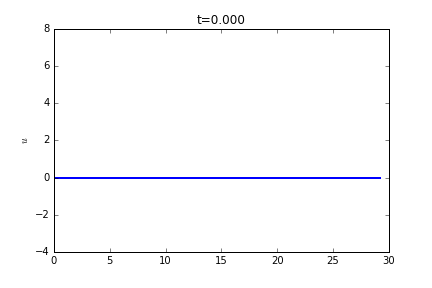
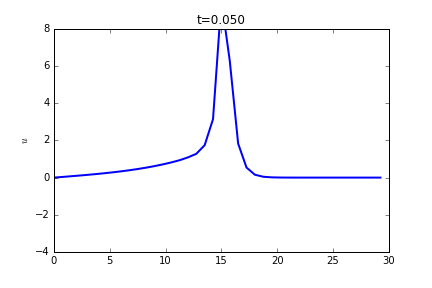
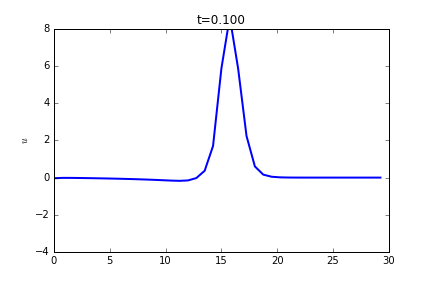
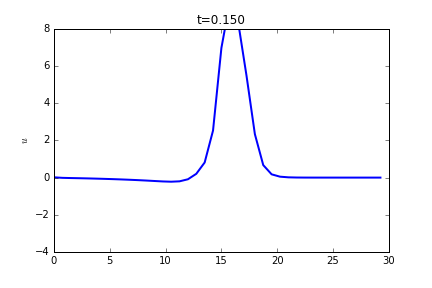
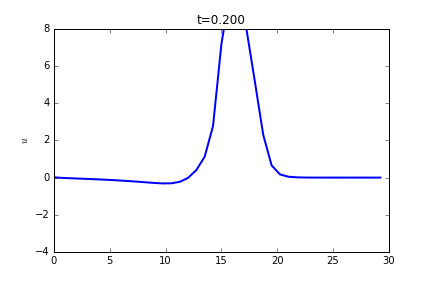
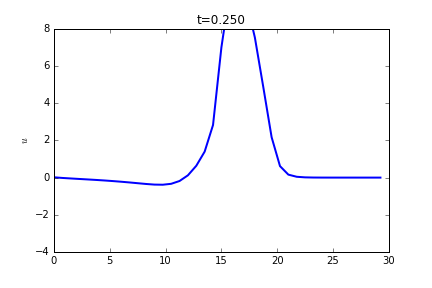
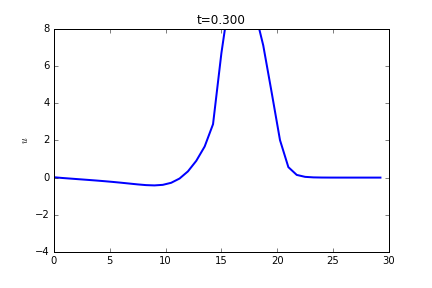
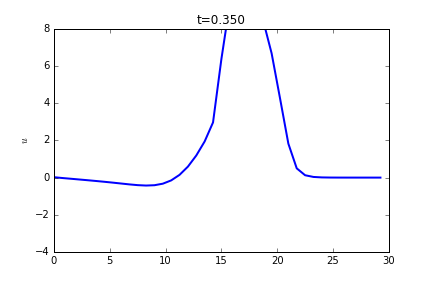
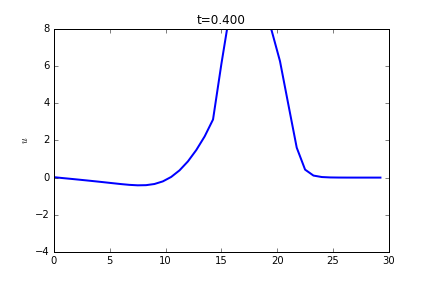
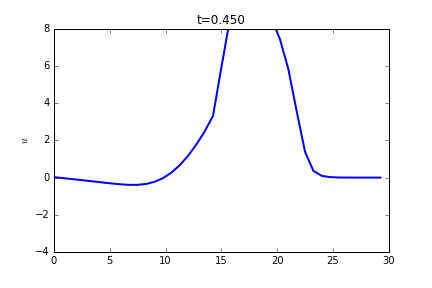
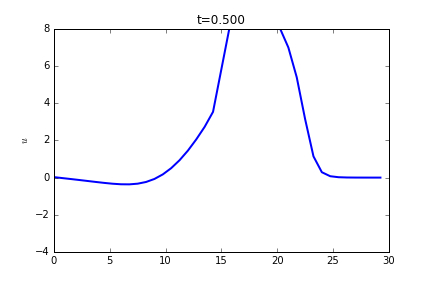
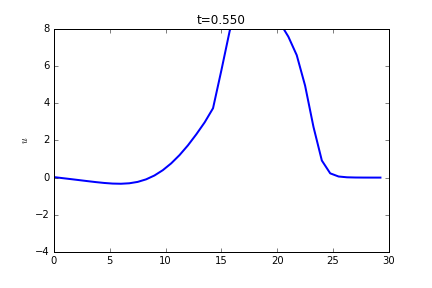
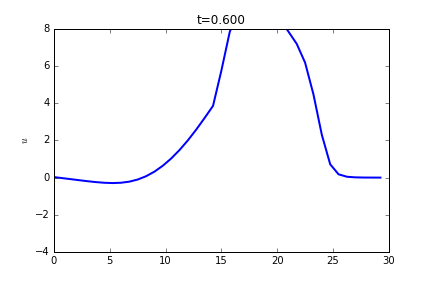
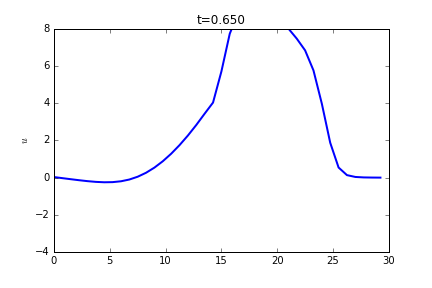
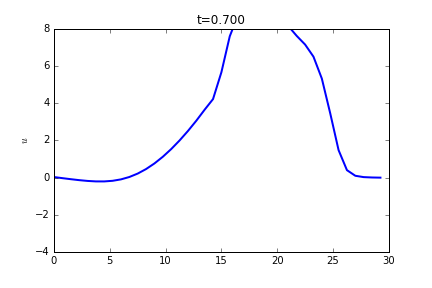
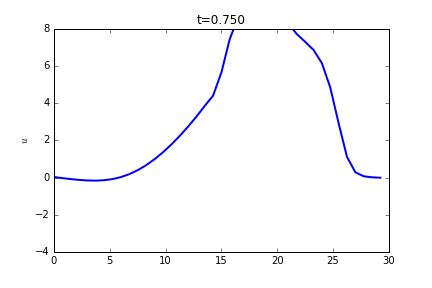
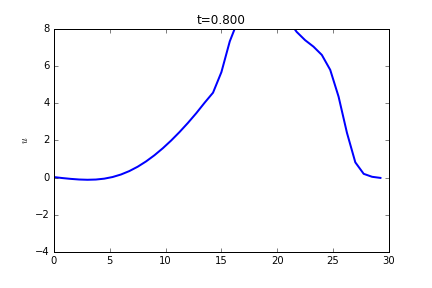
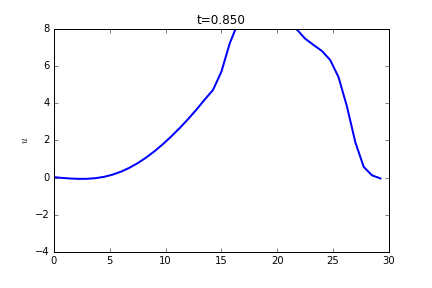
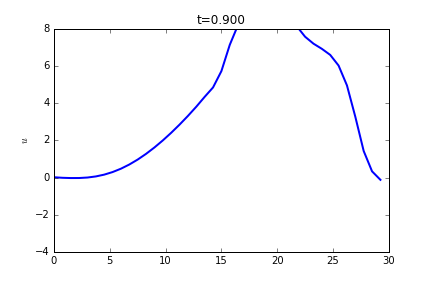
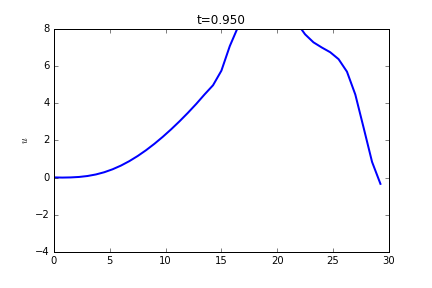
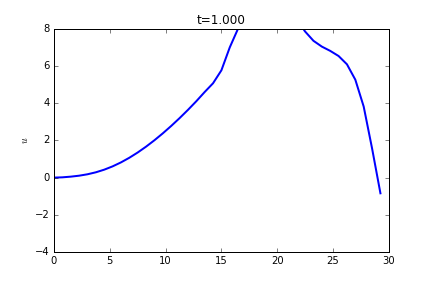
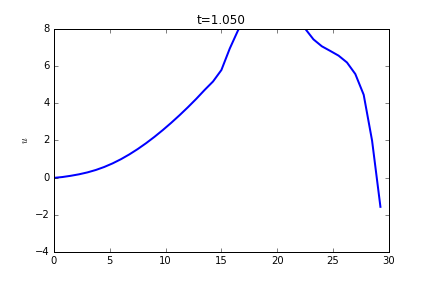
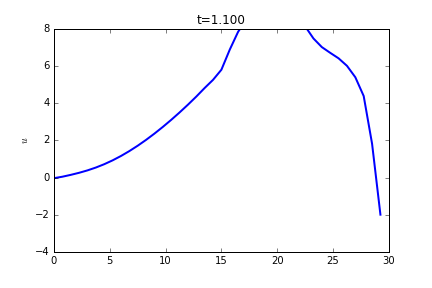
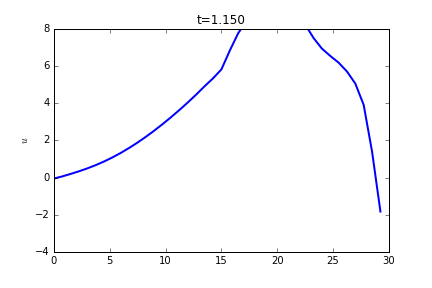
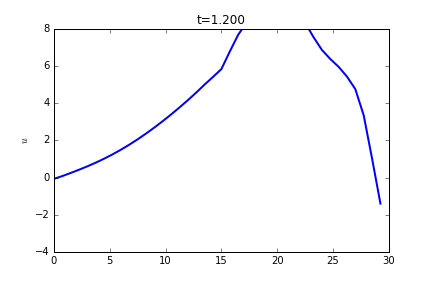
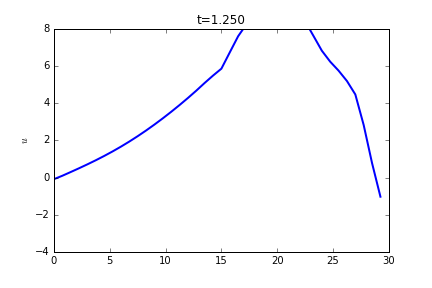
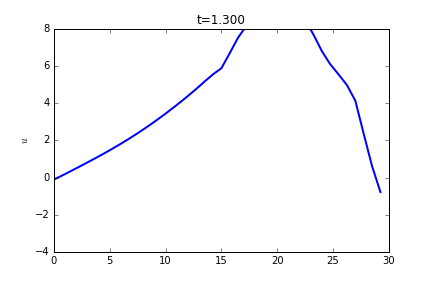
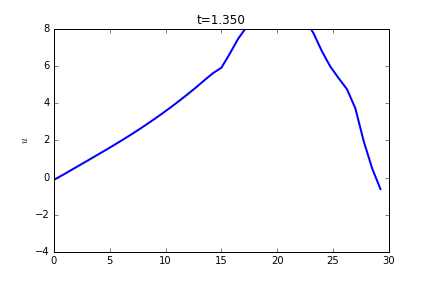
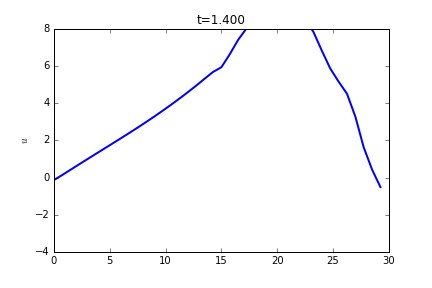
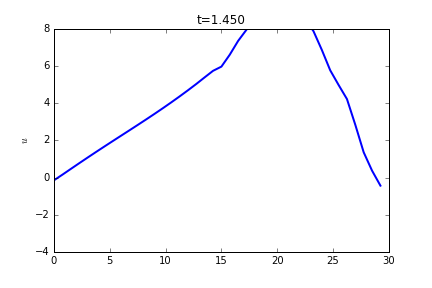
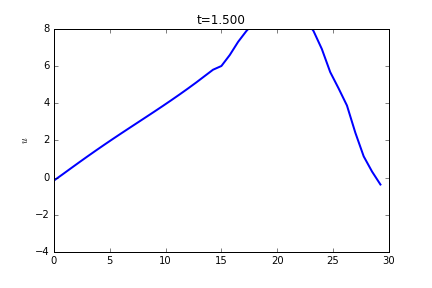
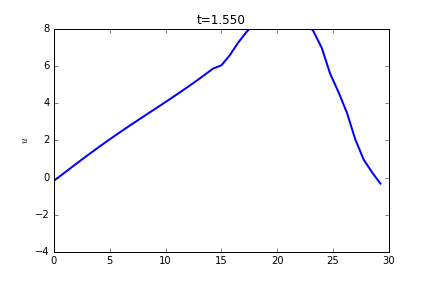
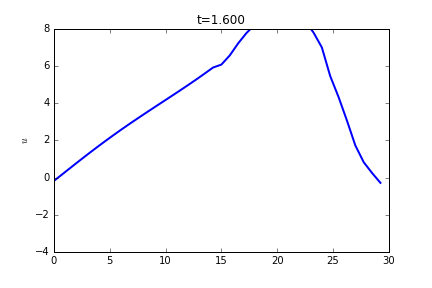
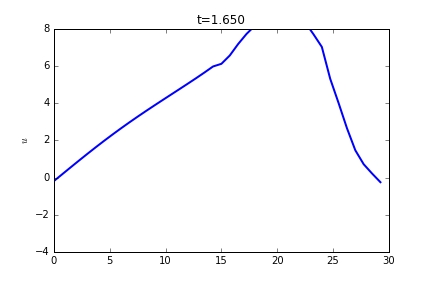
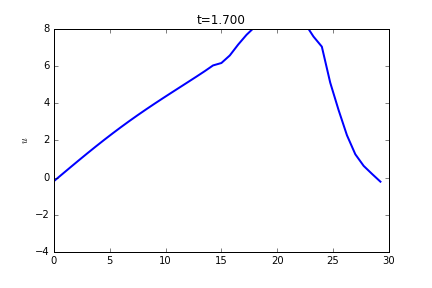
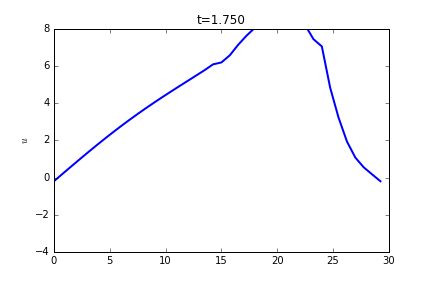
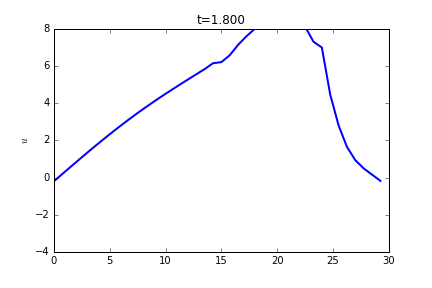
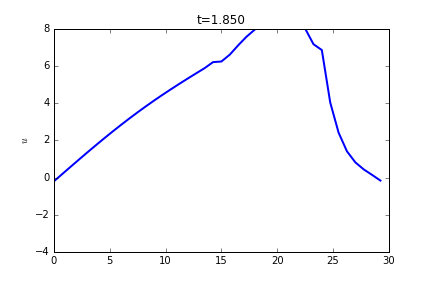
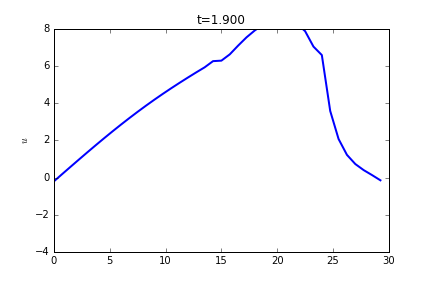
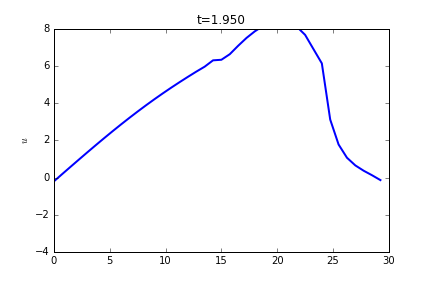
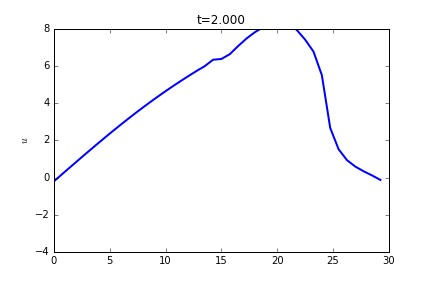
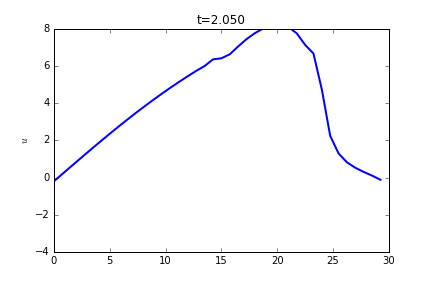
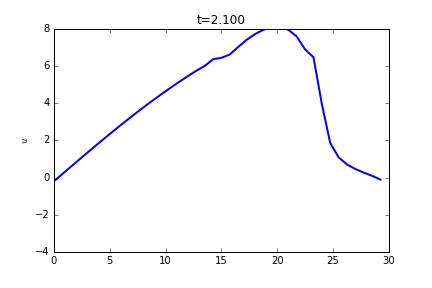
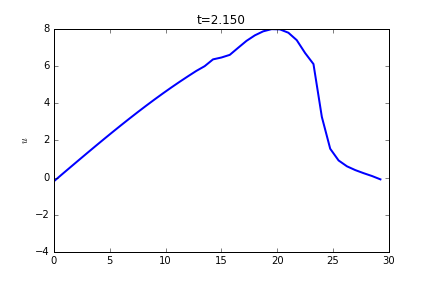
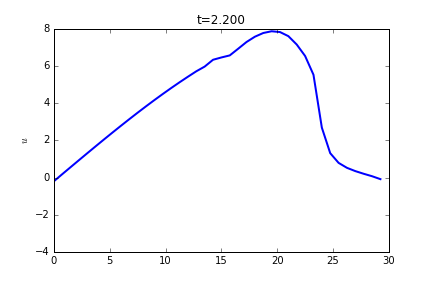
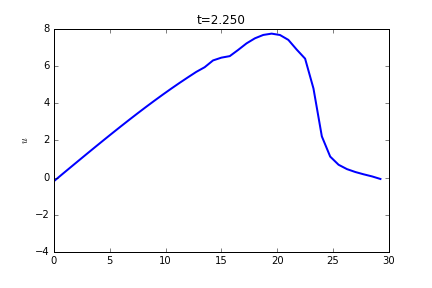
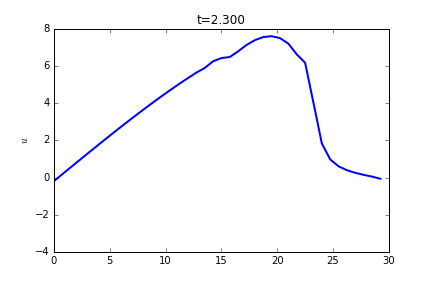
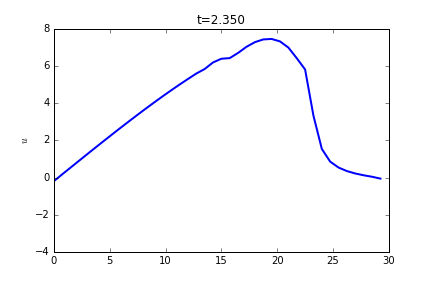
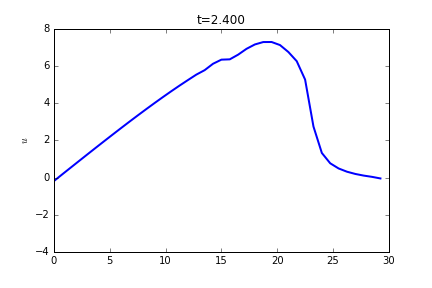
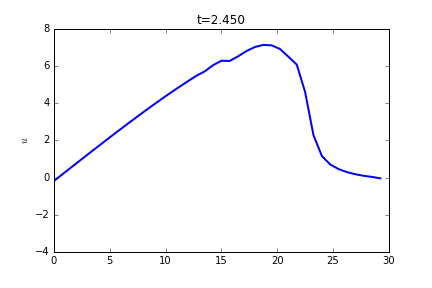
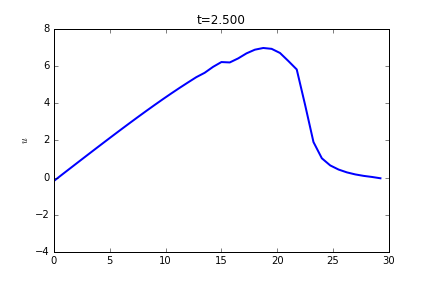
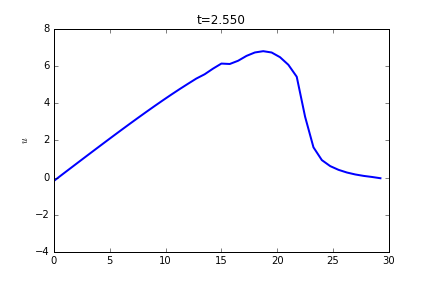
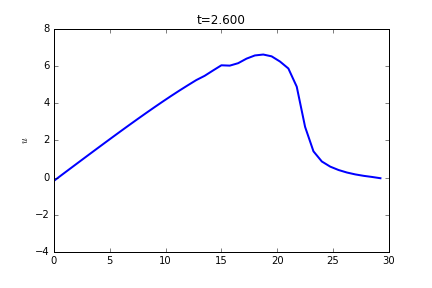
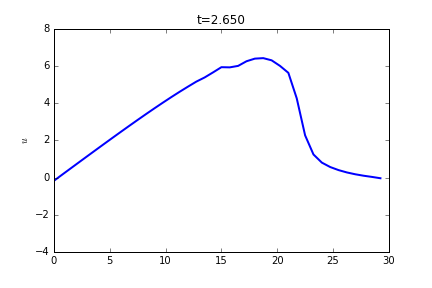
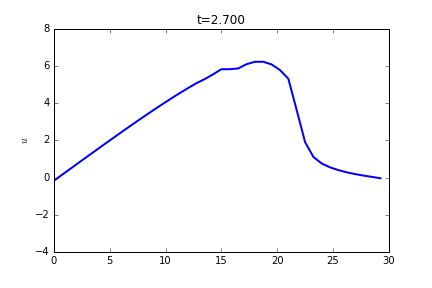
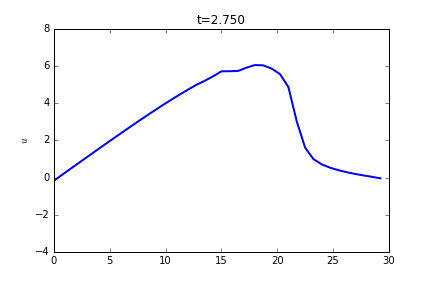
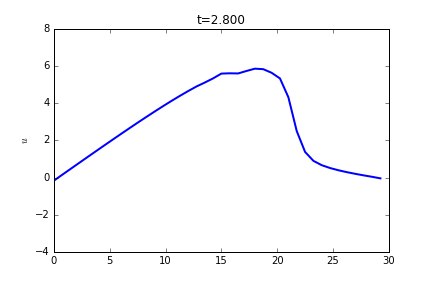
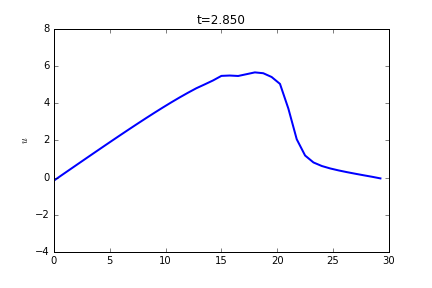
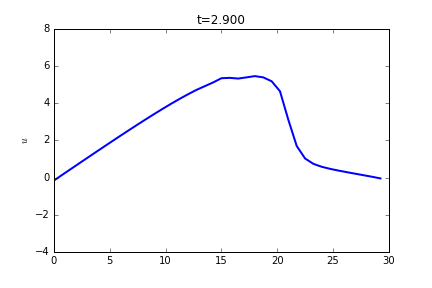
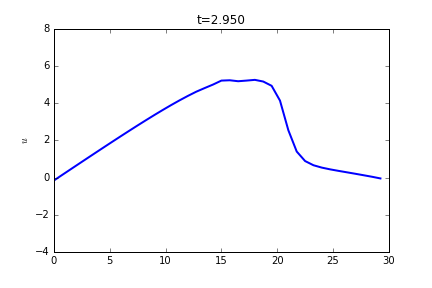
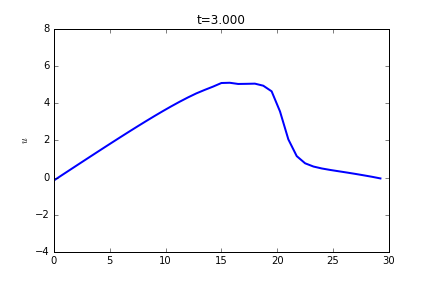
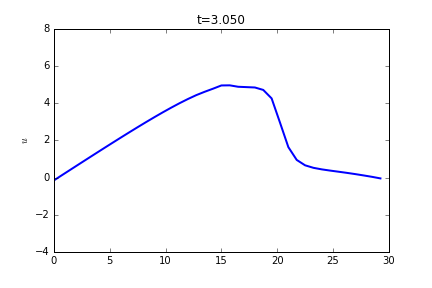
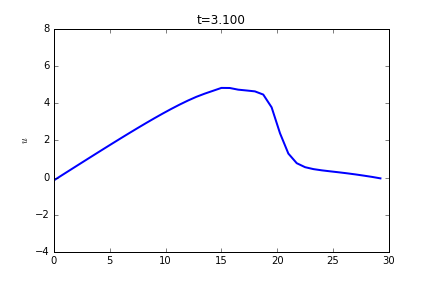
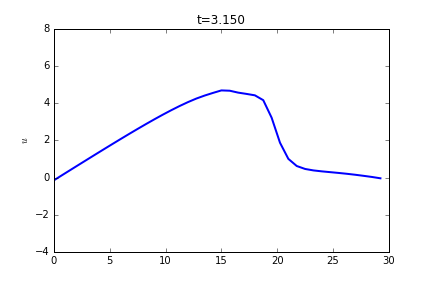
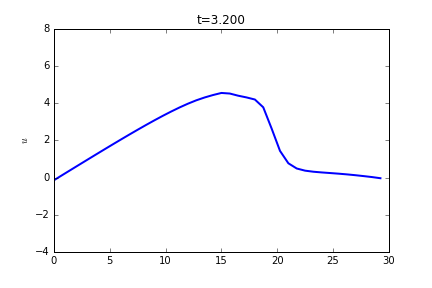
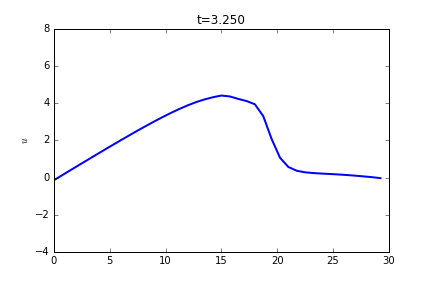
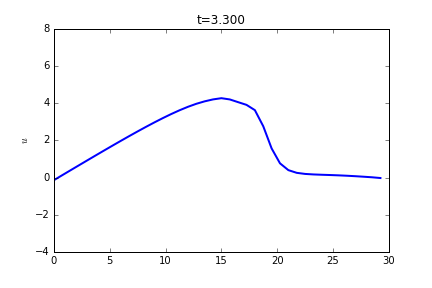
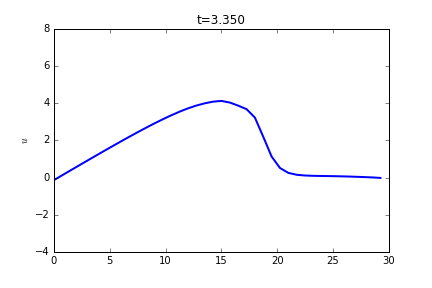
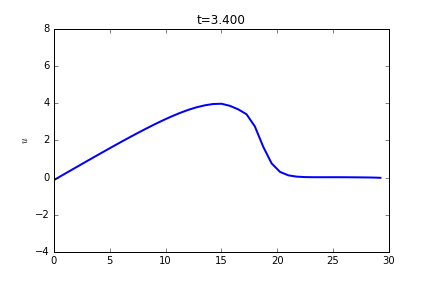
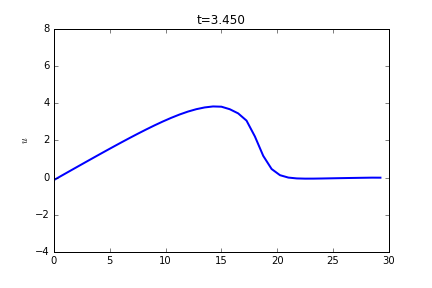
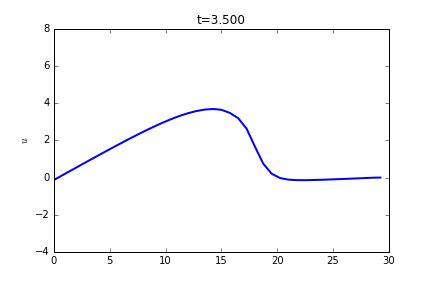
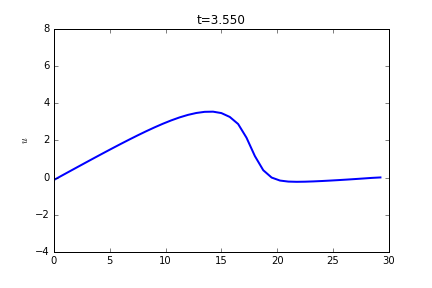
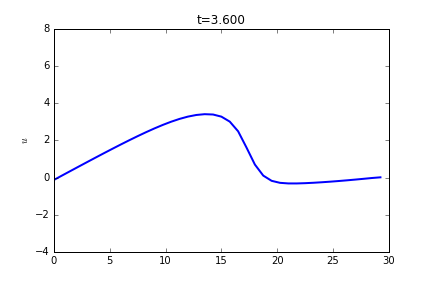
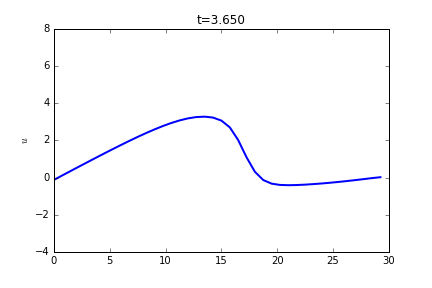
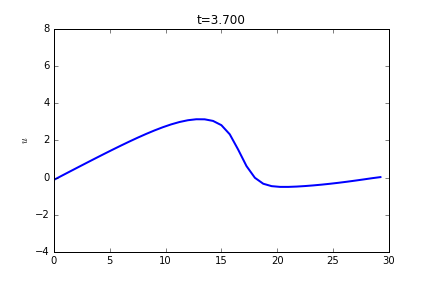
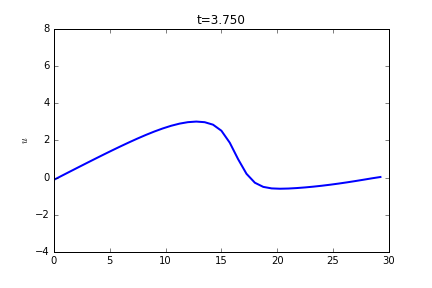
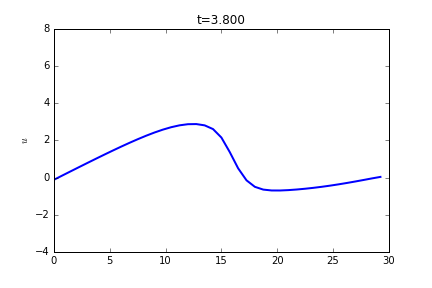
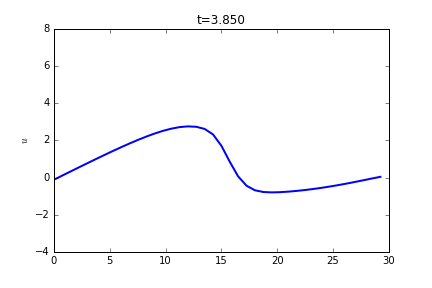
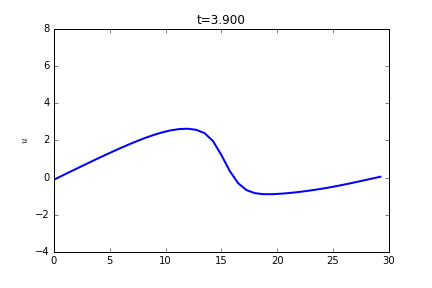
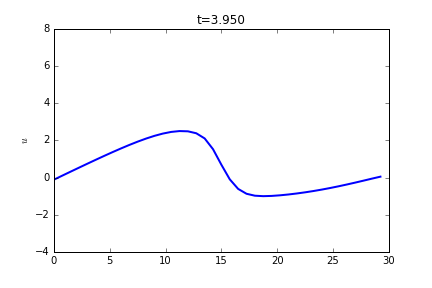
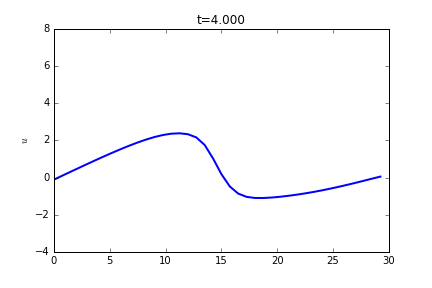
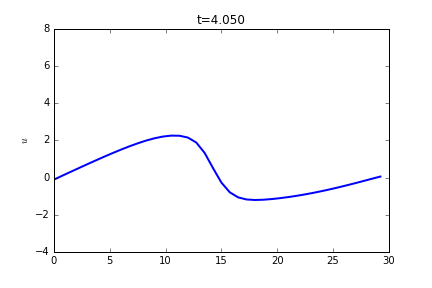
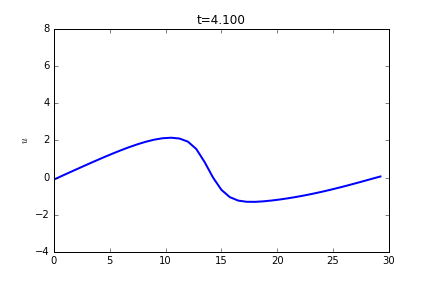
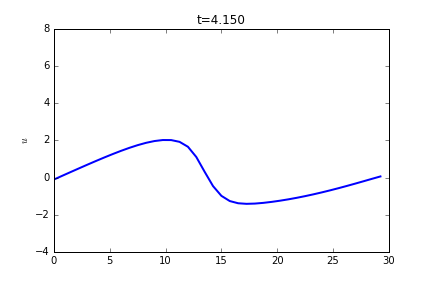
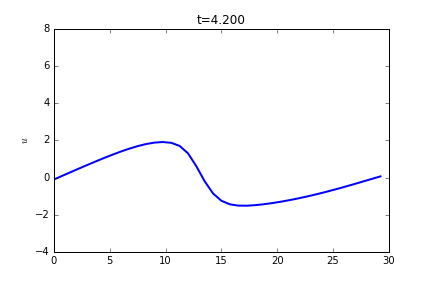
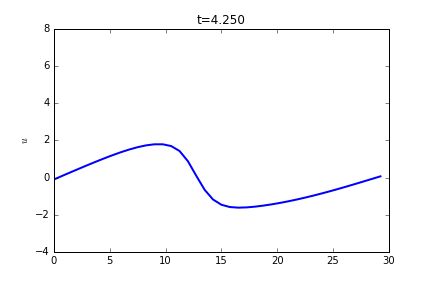
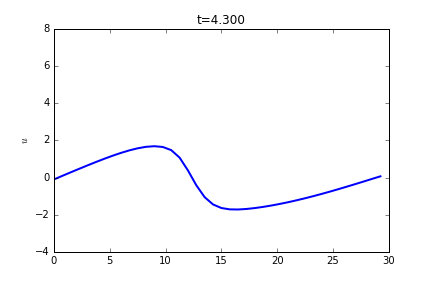
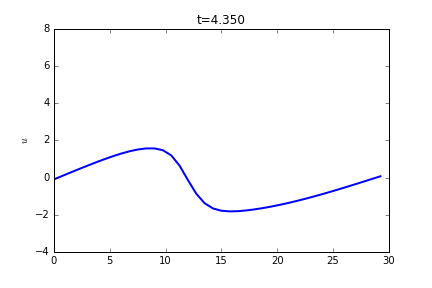
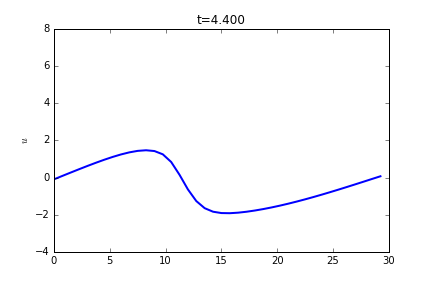
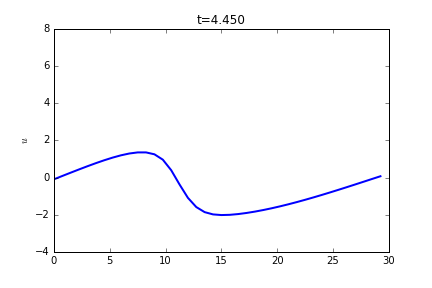
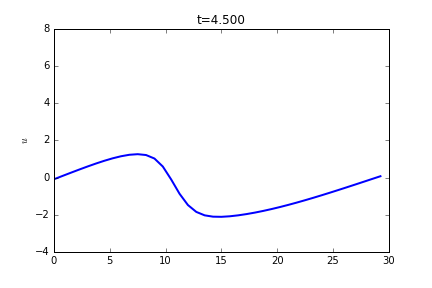
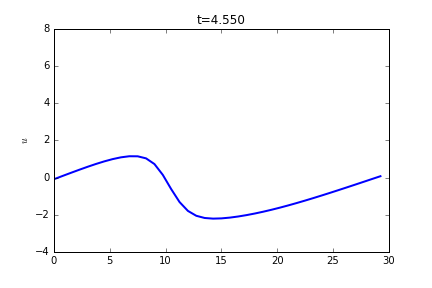
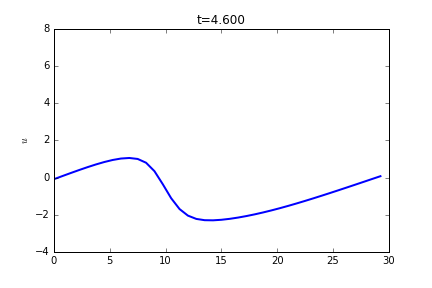
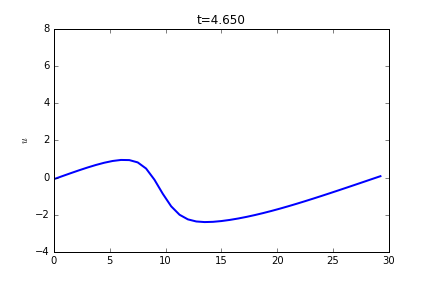
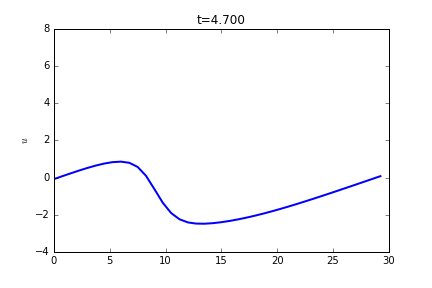
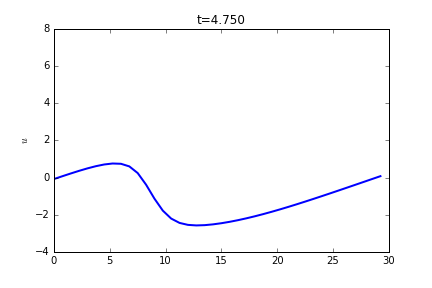
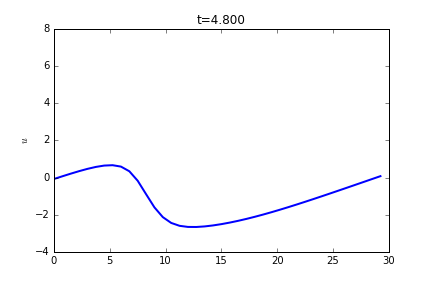
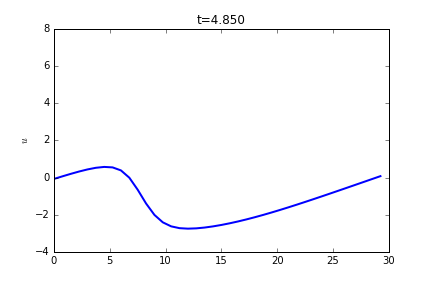
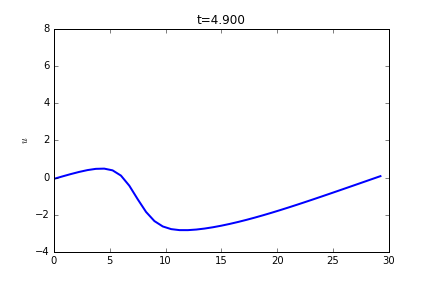
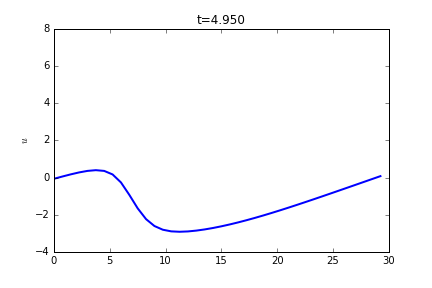
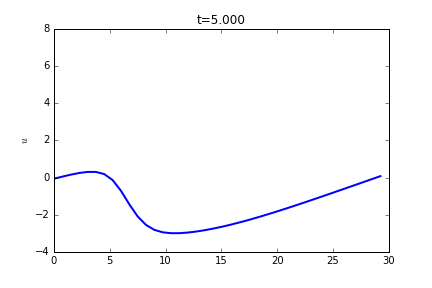
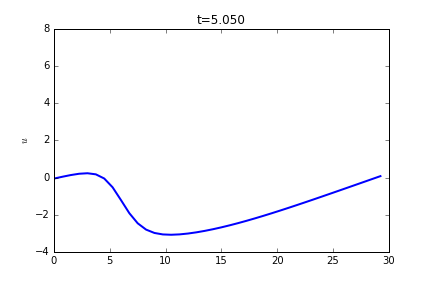
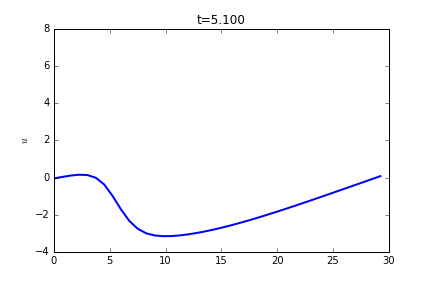
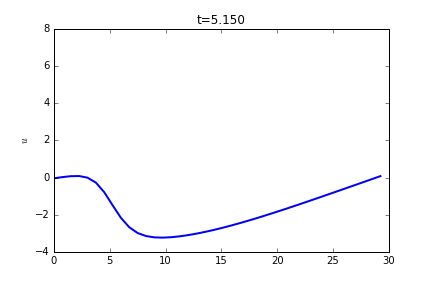
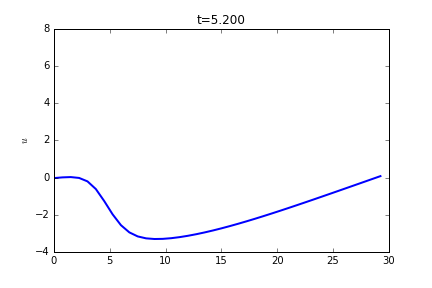
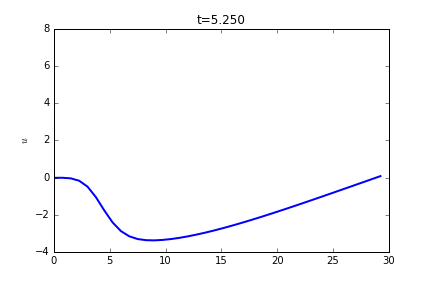
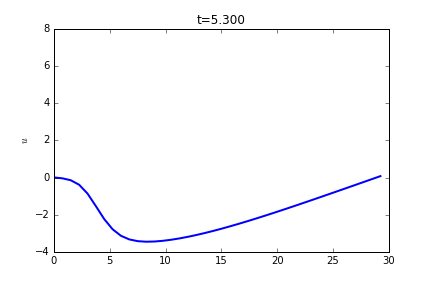
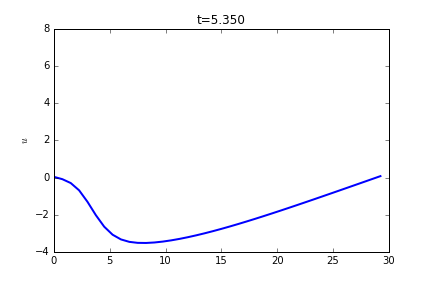
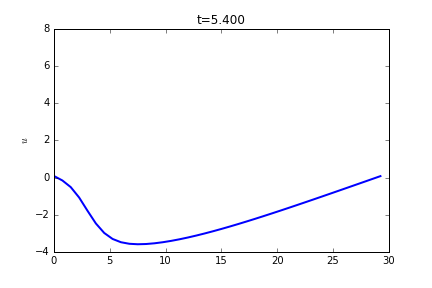
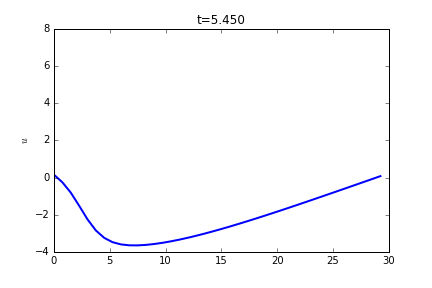
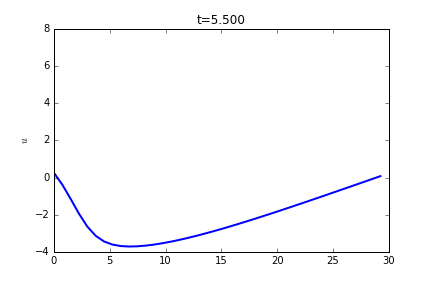
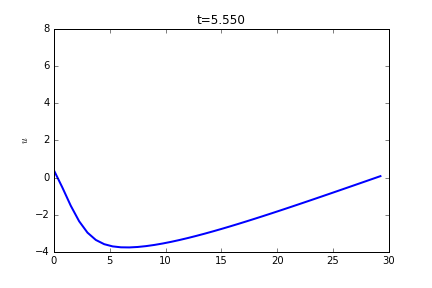
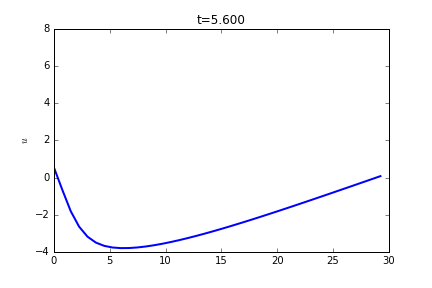
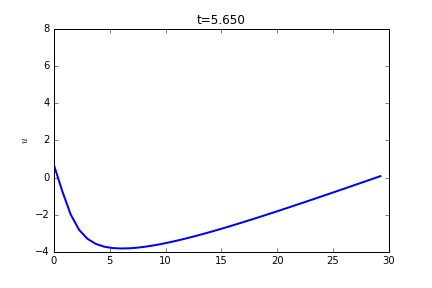
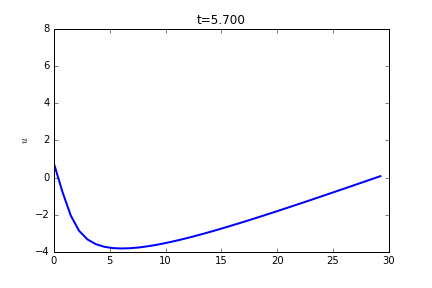
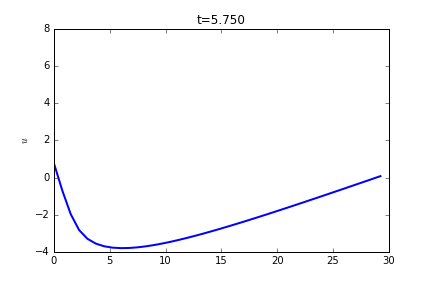
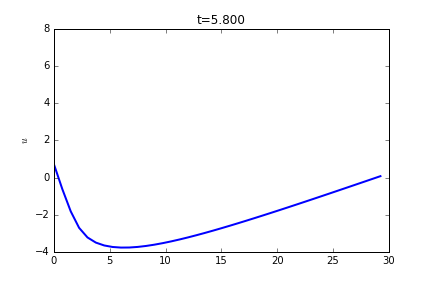
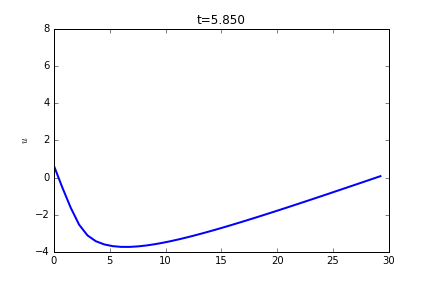
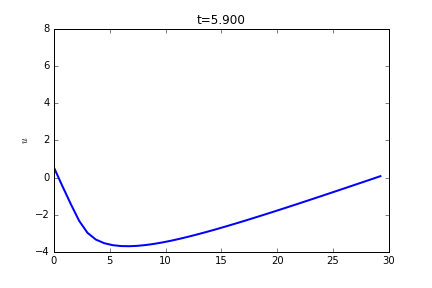
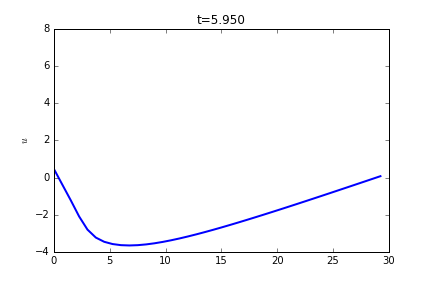
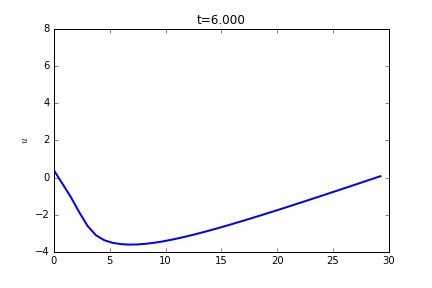
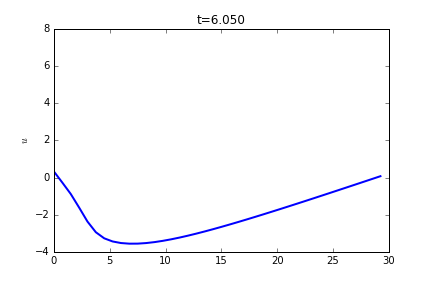
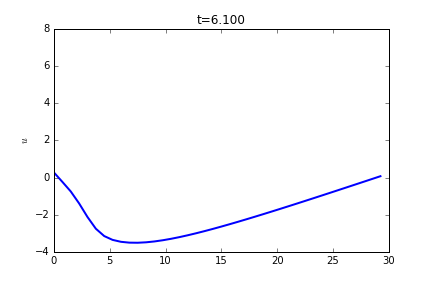
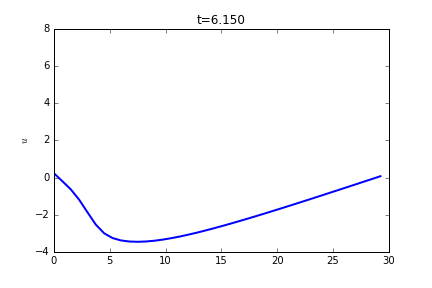
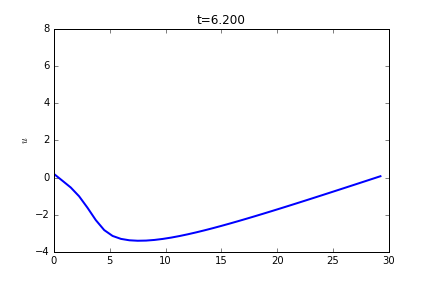
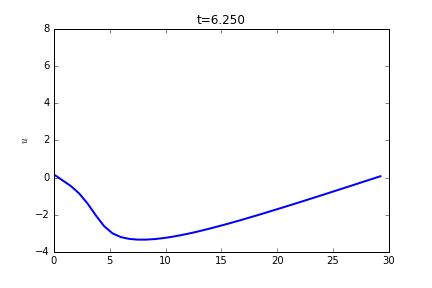
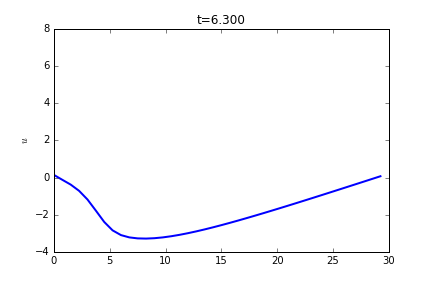
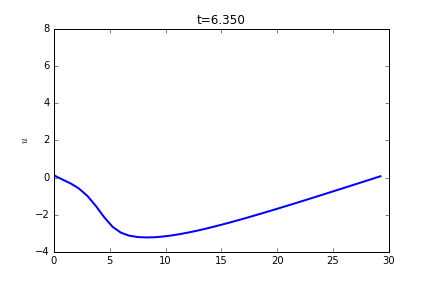
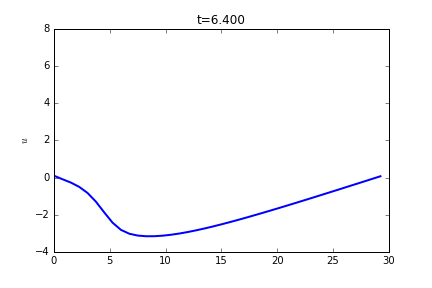
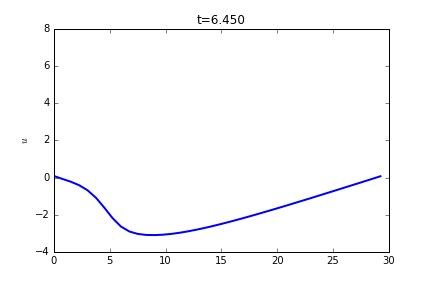
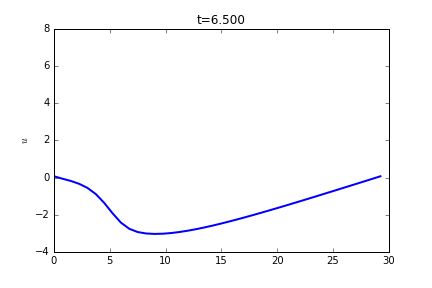
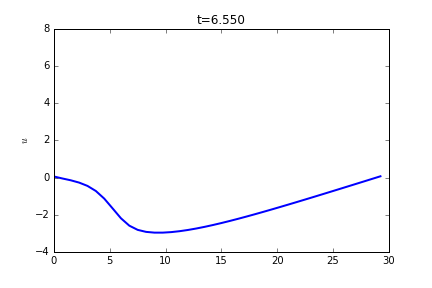
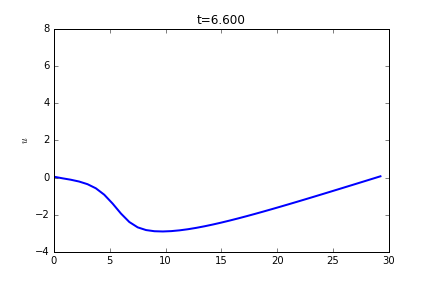
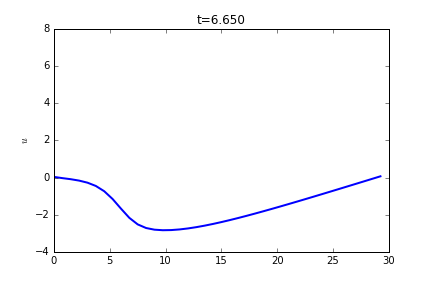
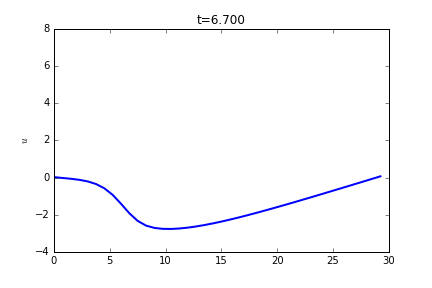
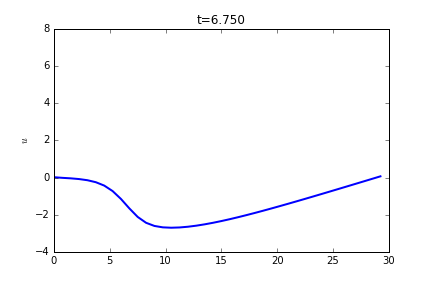
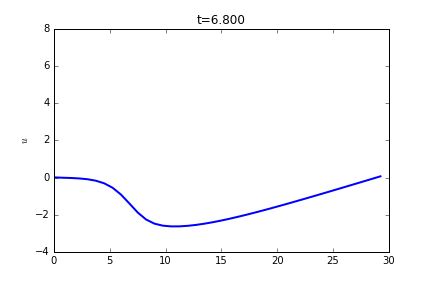
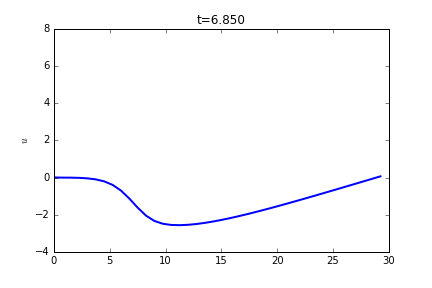
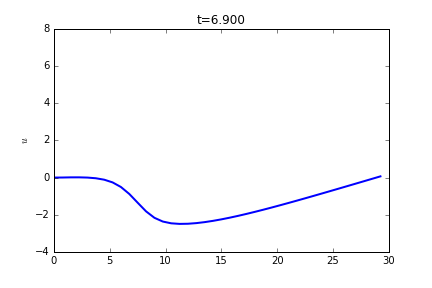
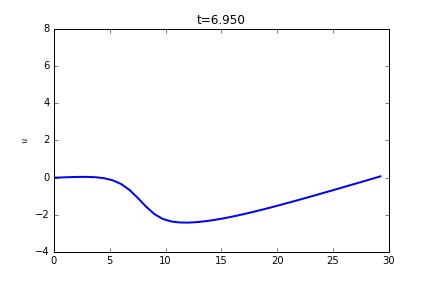
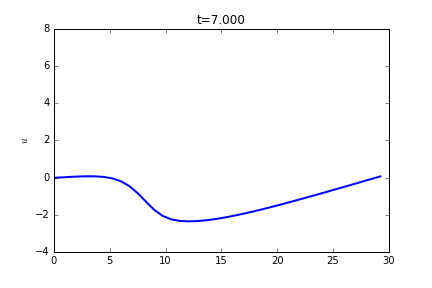
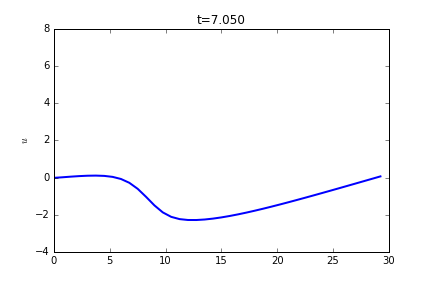
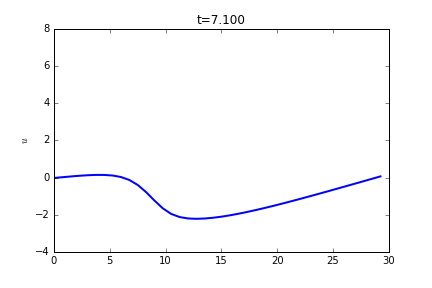
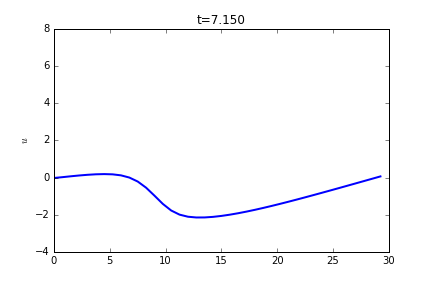
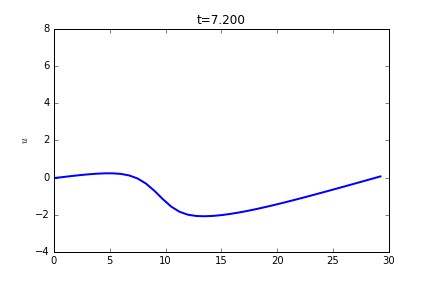
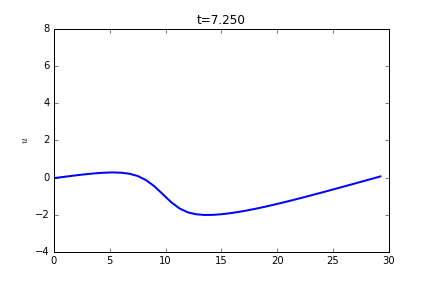
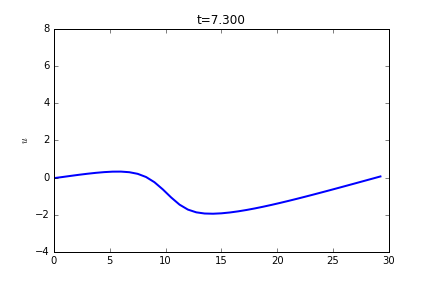
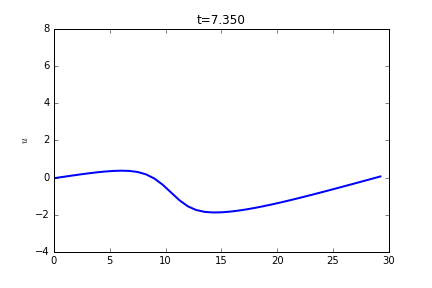
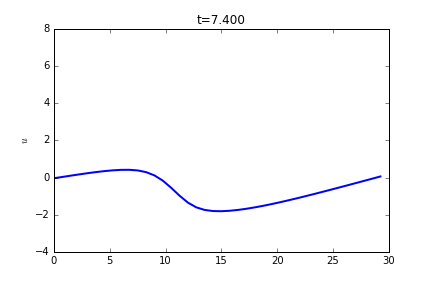
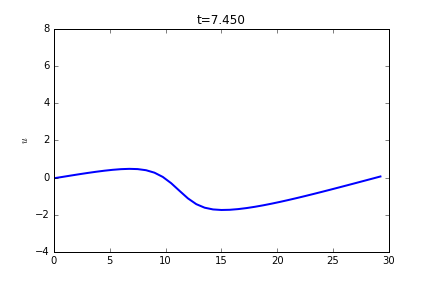
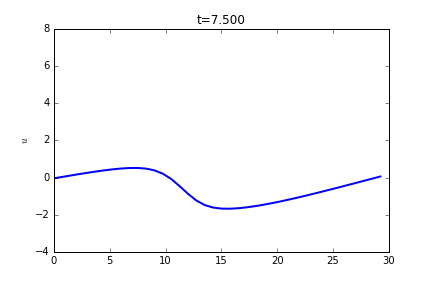
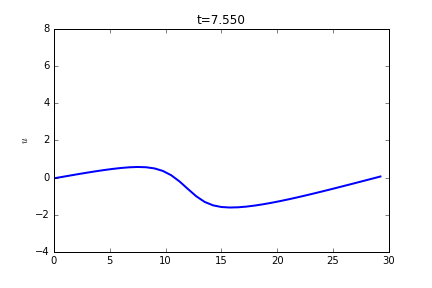
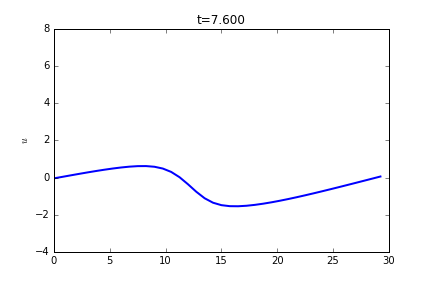
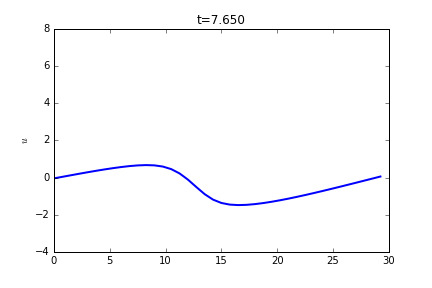
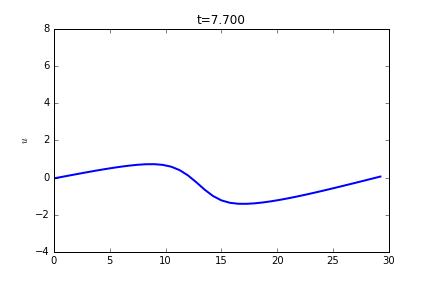
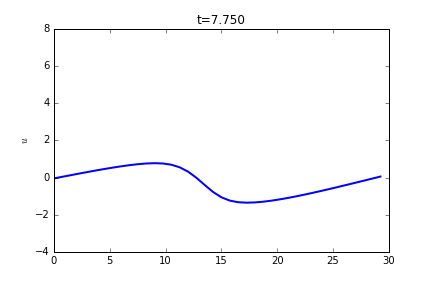
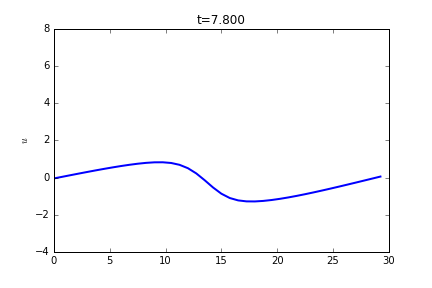
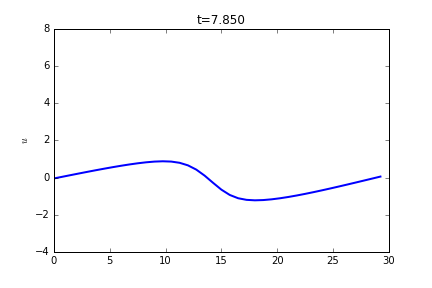
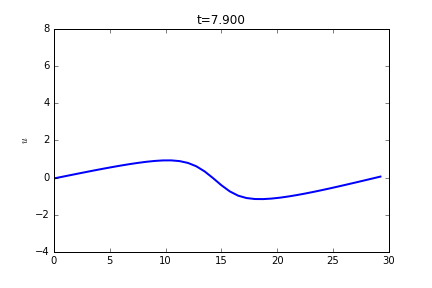
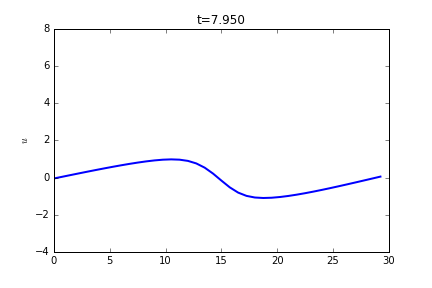
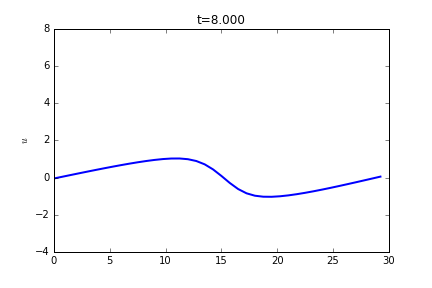
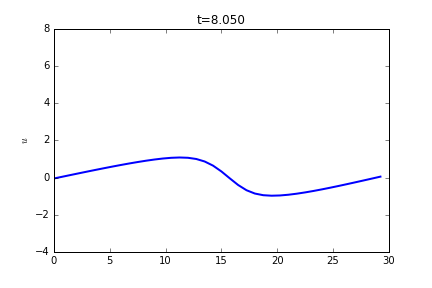
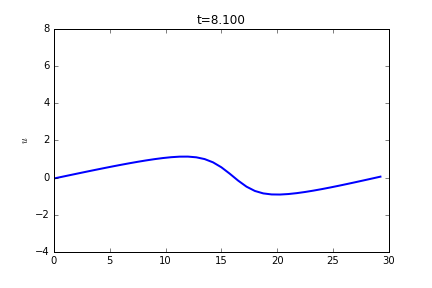
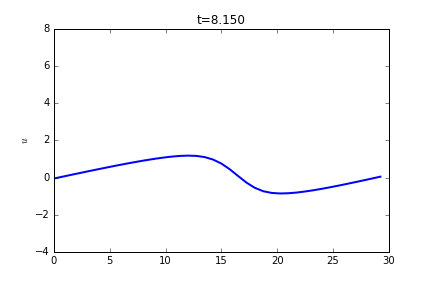
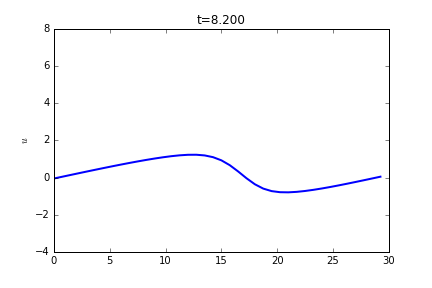
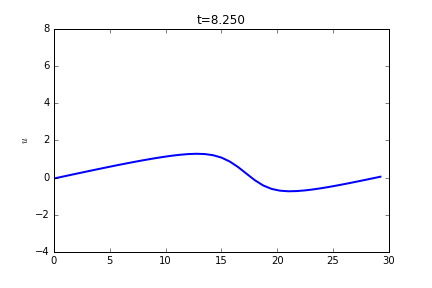
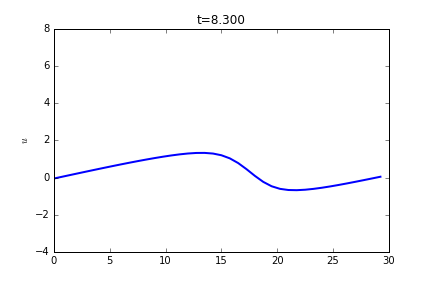
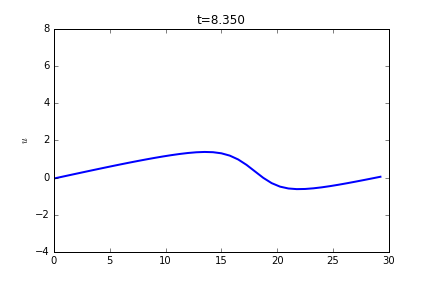
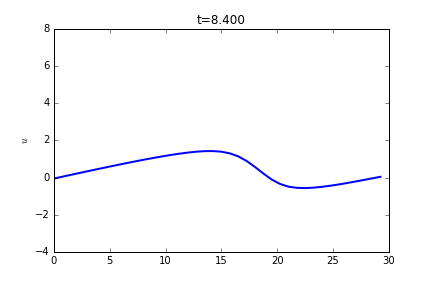
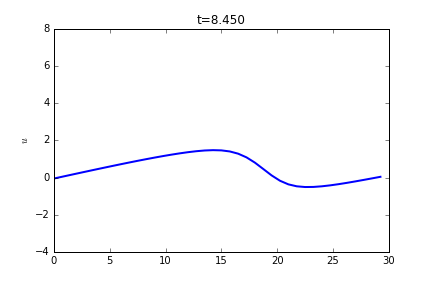
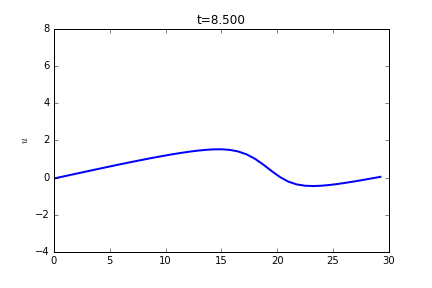
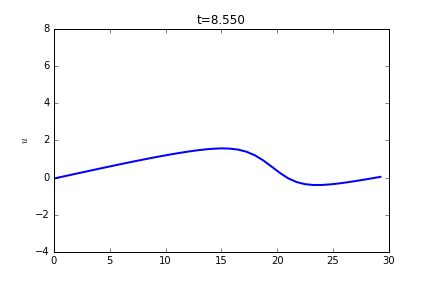
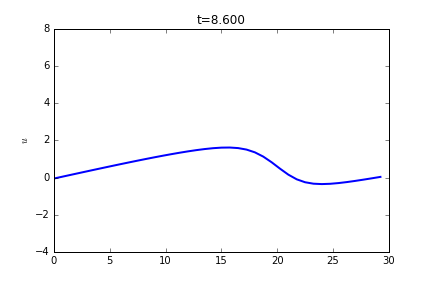
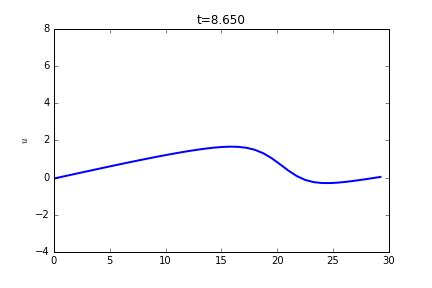
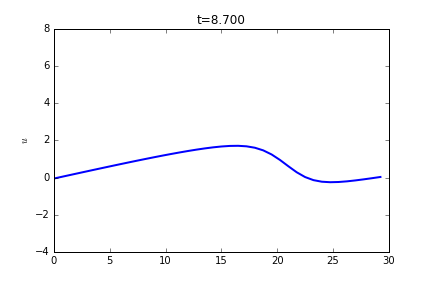
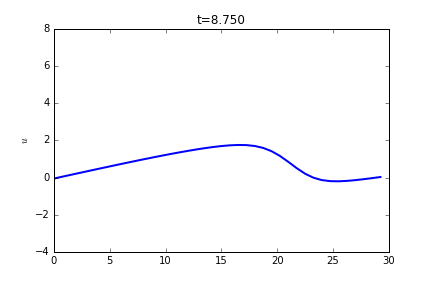
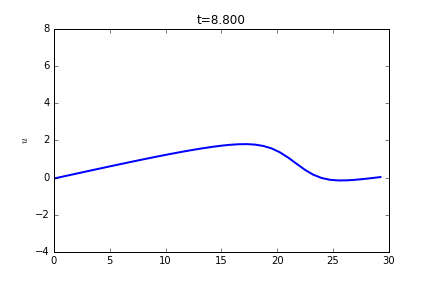
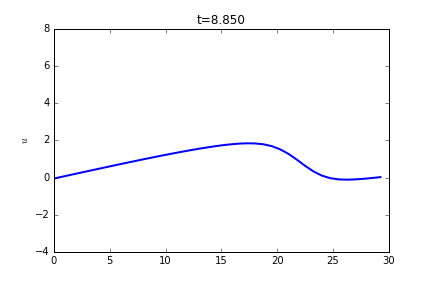
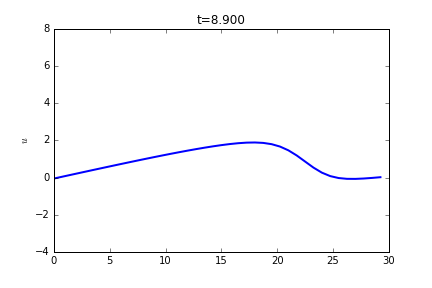
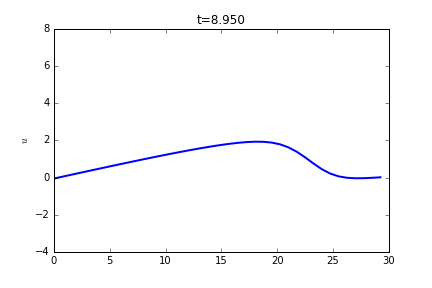
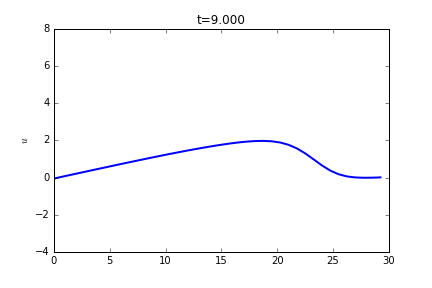
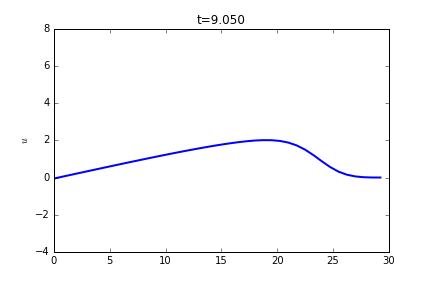
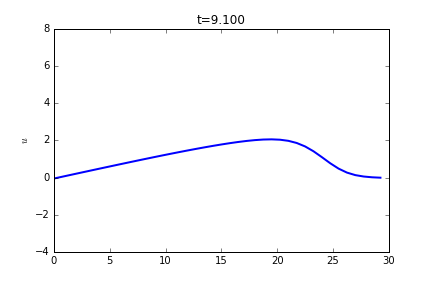
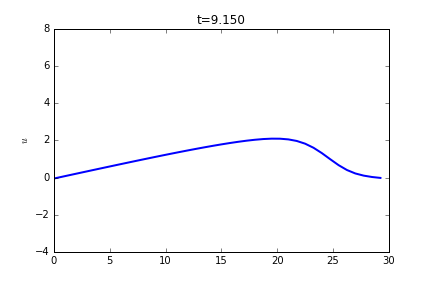
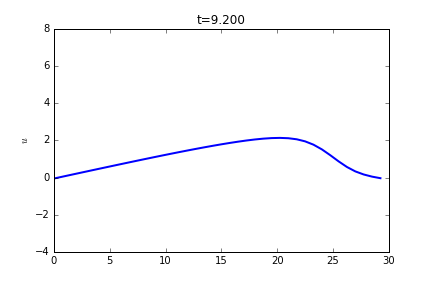
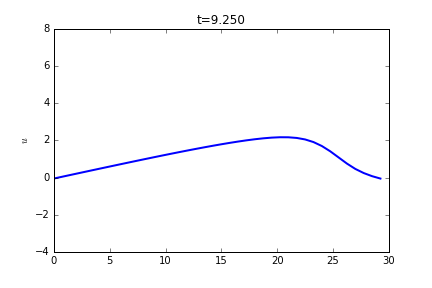
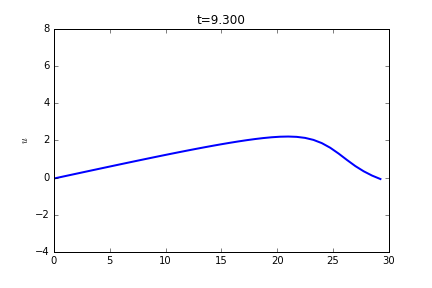
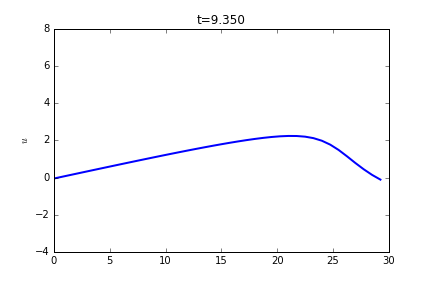
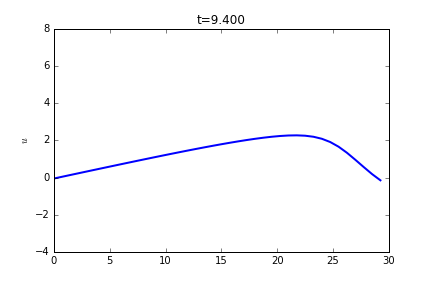
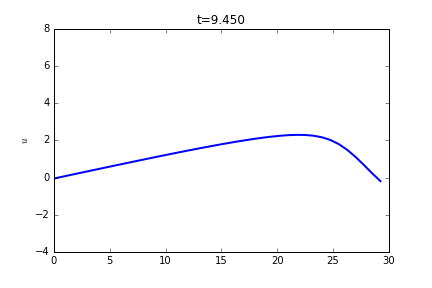
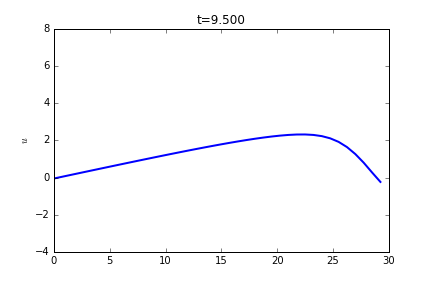
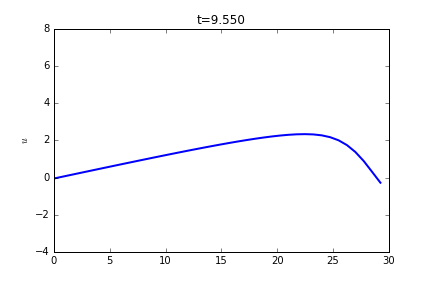
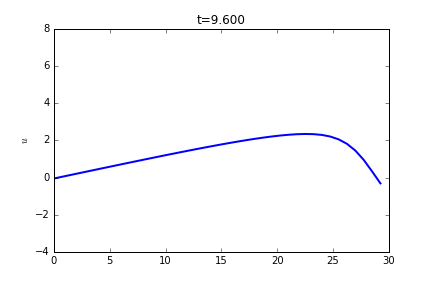
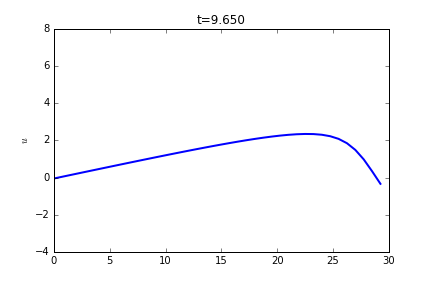
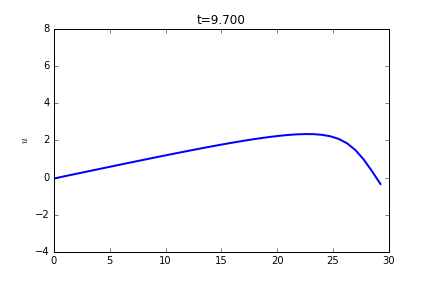
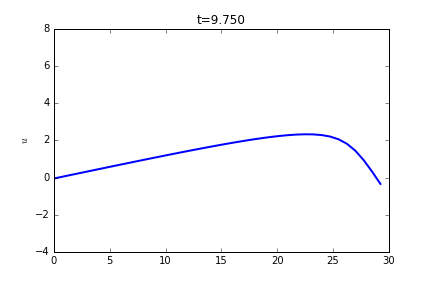
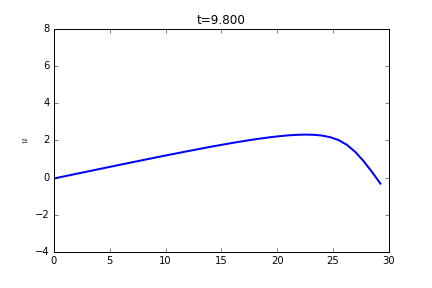
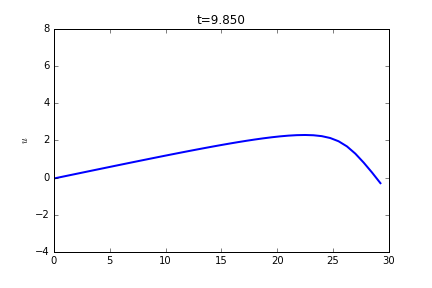
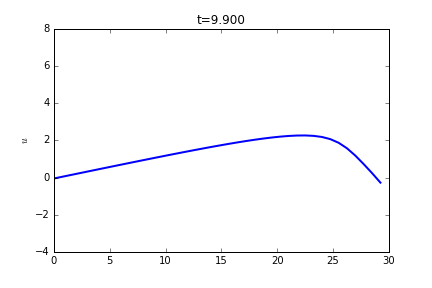
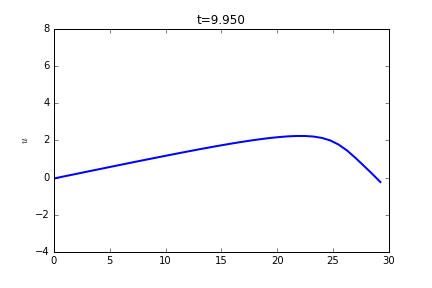
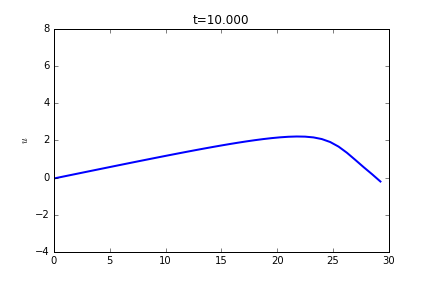

In [9]:
gF.plotAnimation(x,uall,tall,xmin,xmax,-4,8)

*** Plotting animation ...



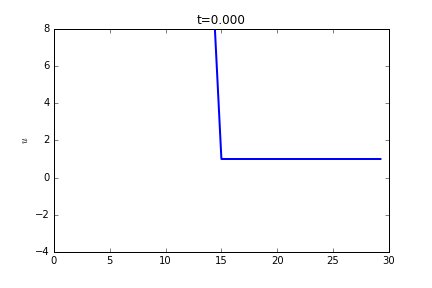
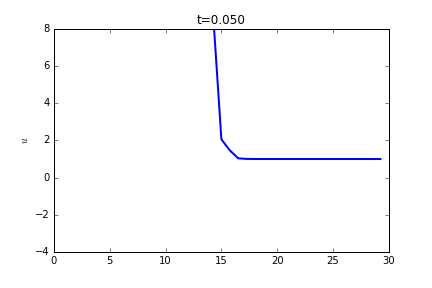
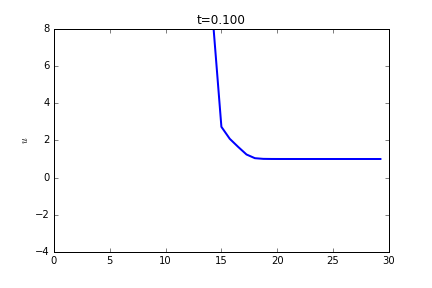
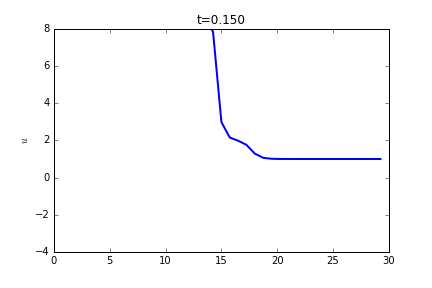
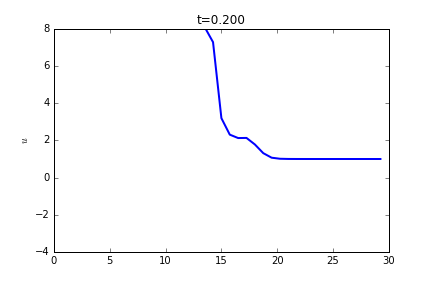
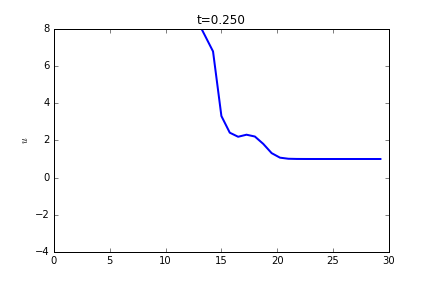
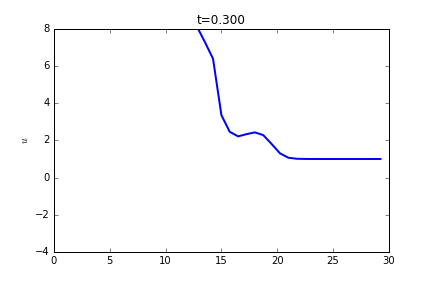
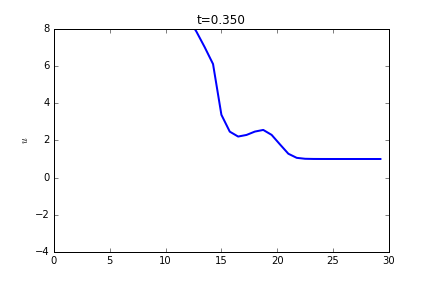
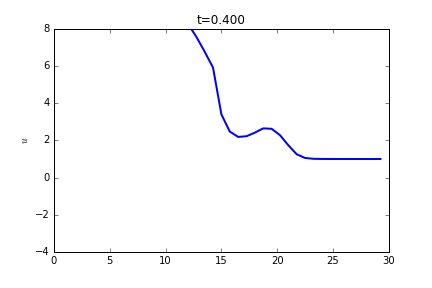
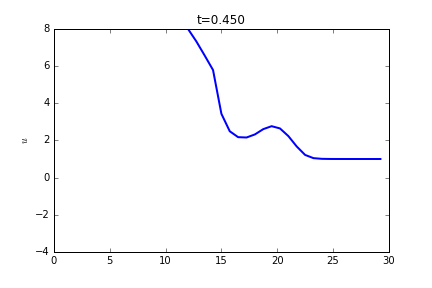
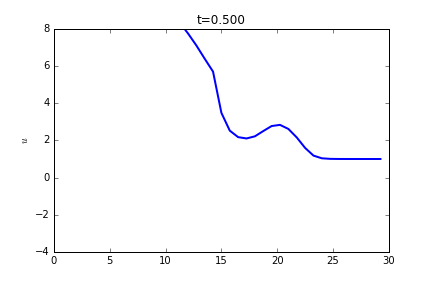
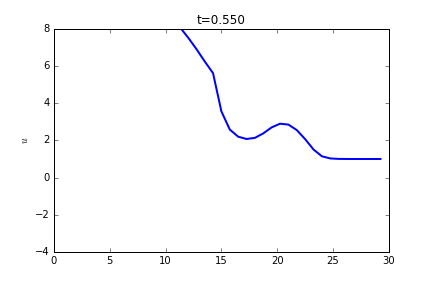
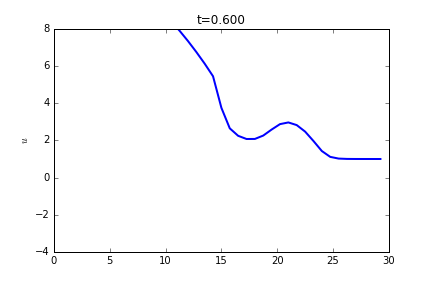
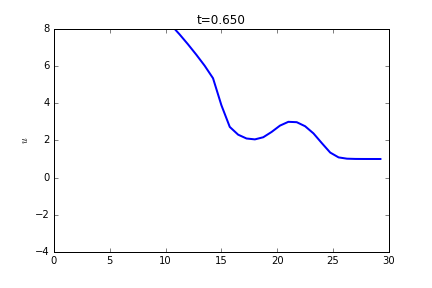
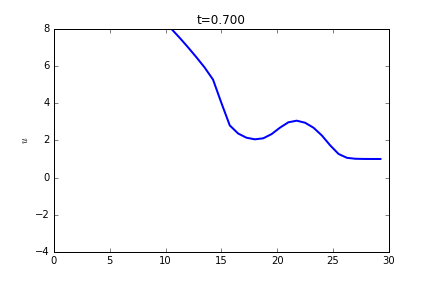
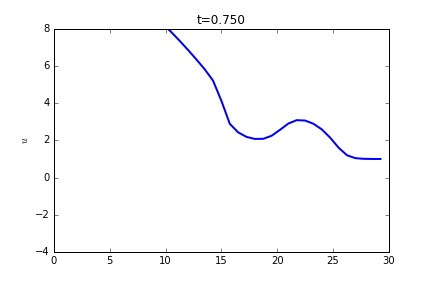
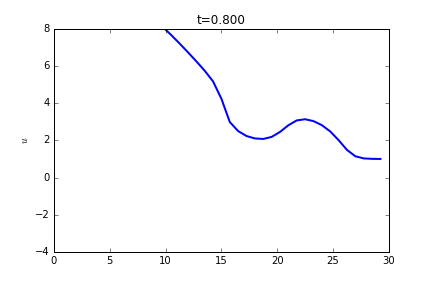
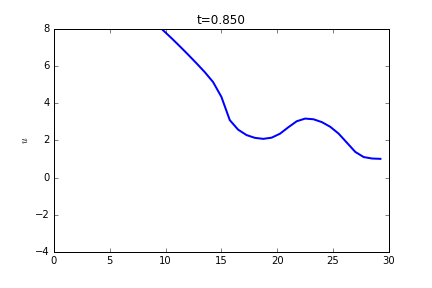
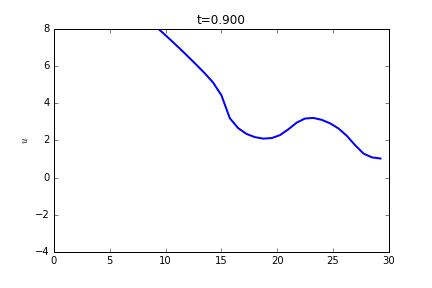
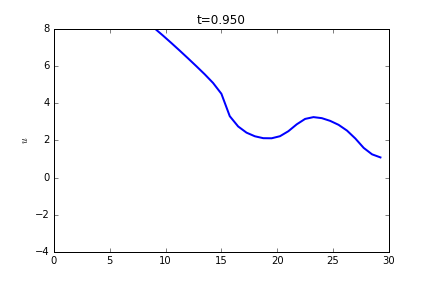
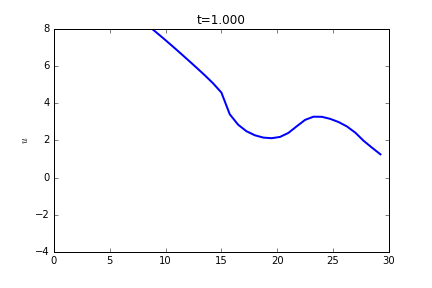
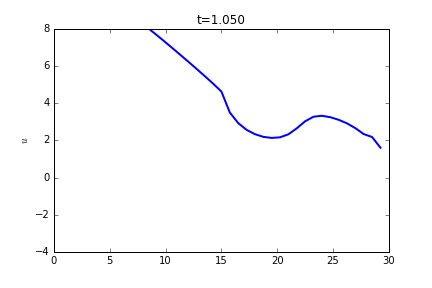
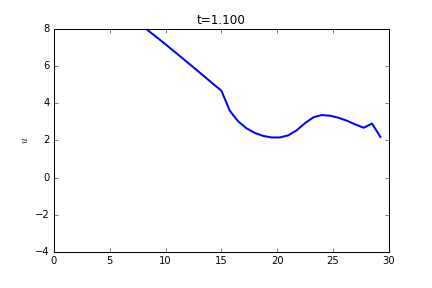
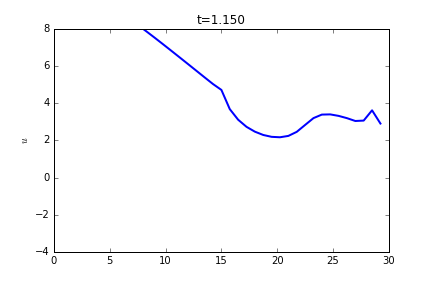
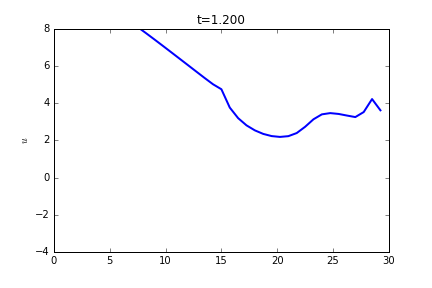
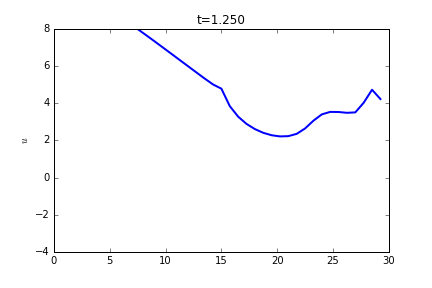
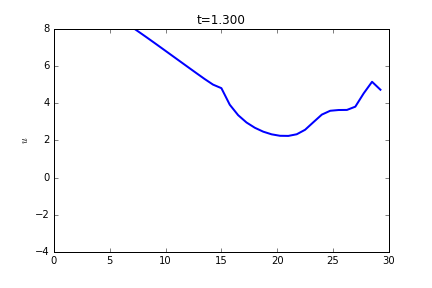
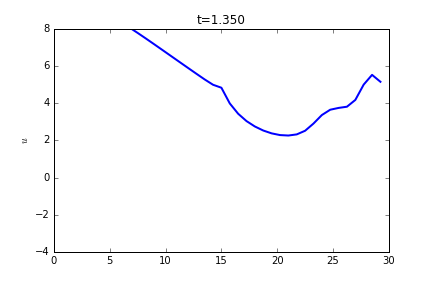
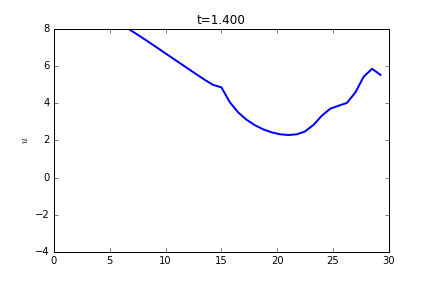
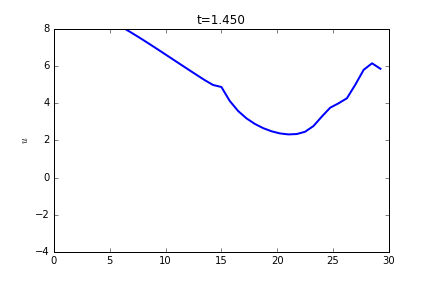
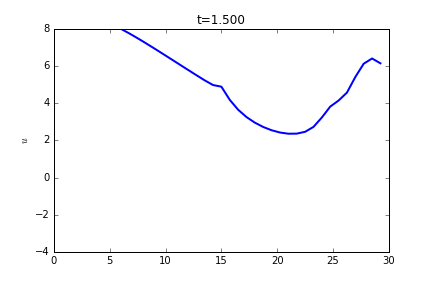
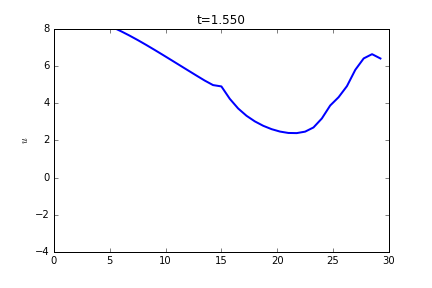
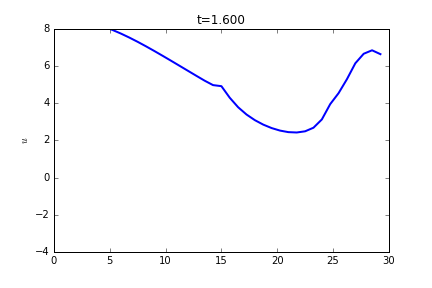
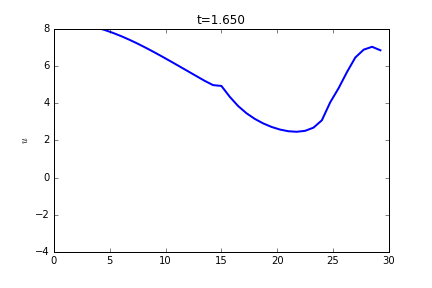
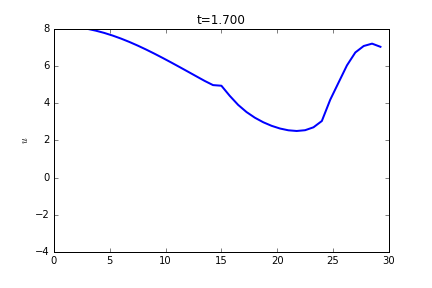
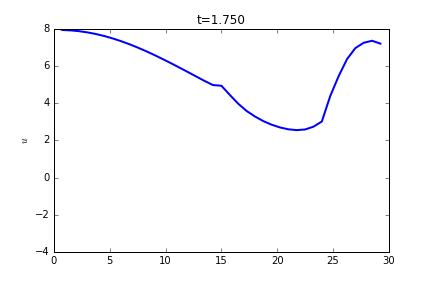
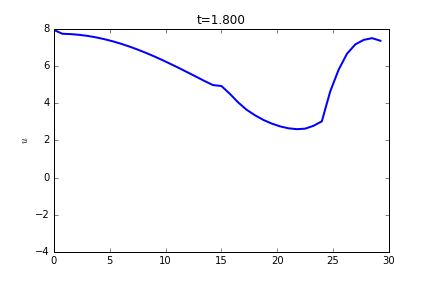
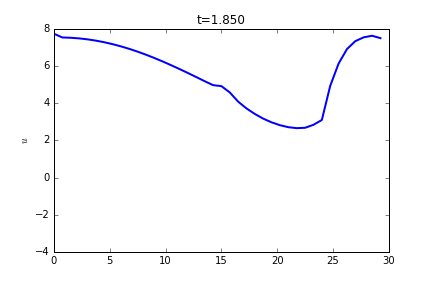
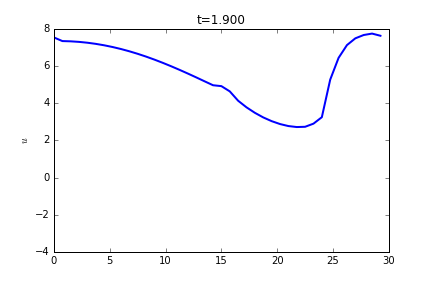
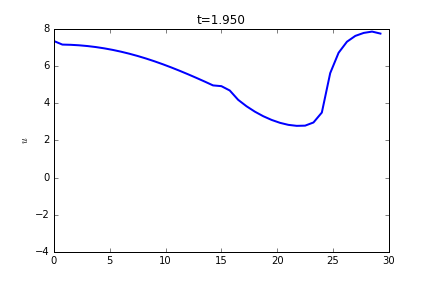
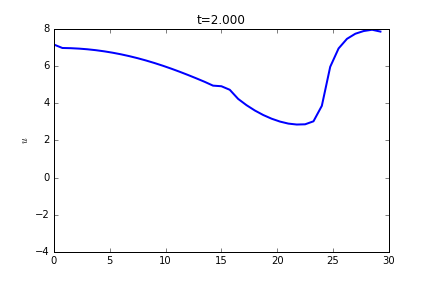
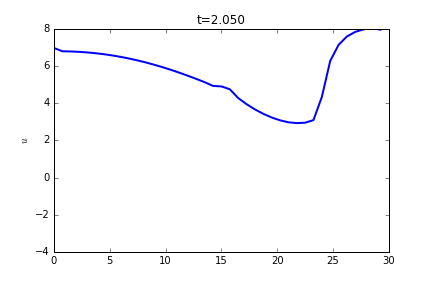
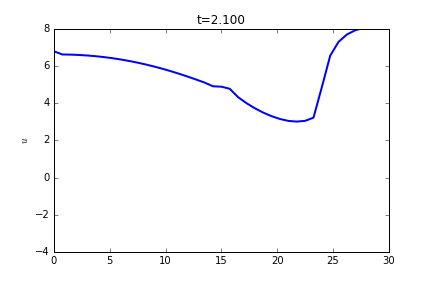
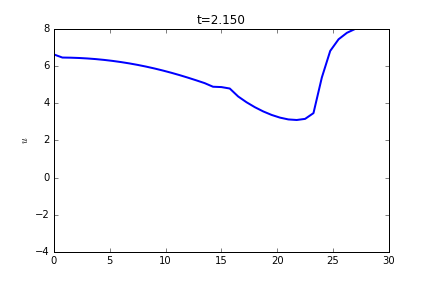
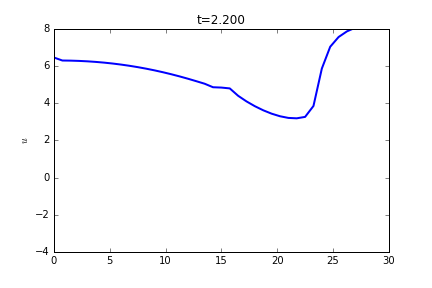
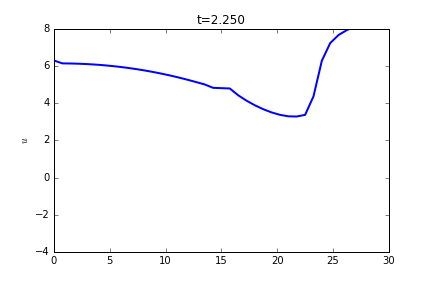
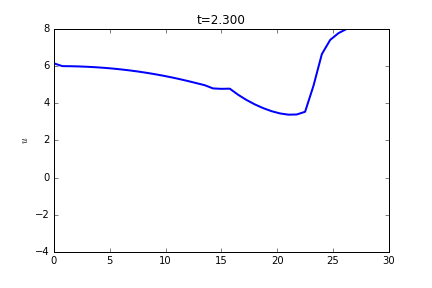
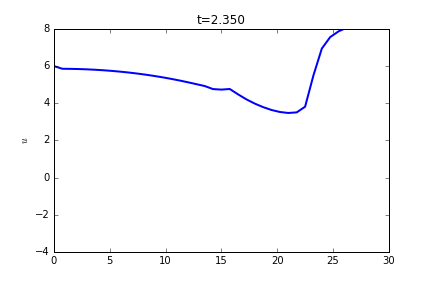
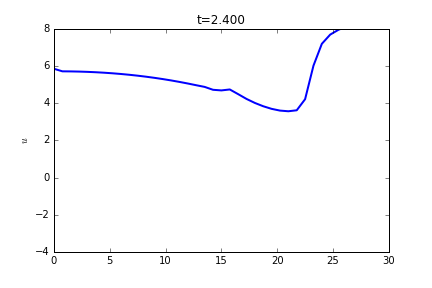
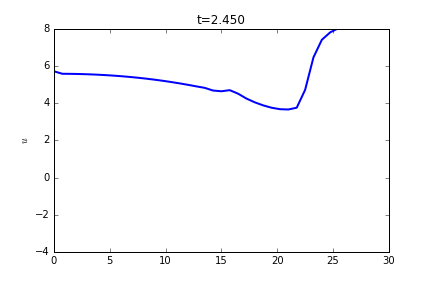
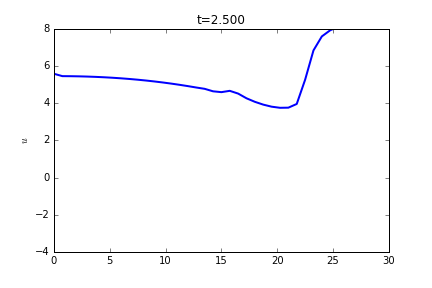
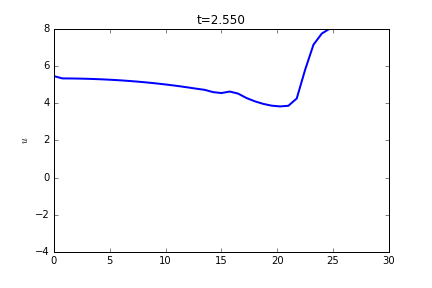
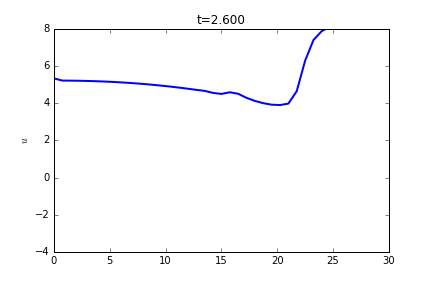
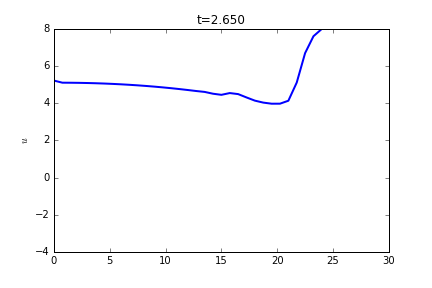
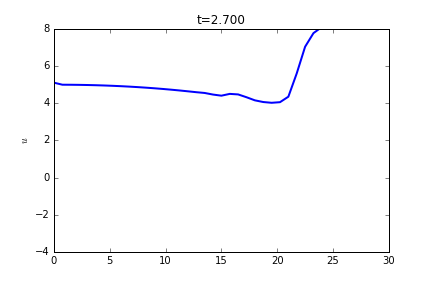
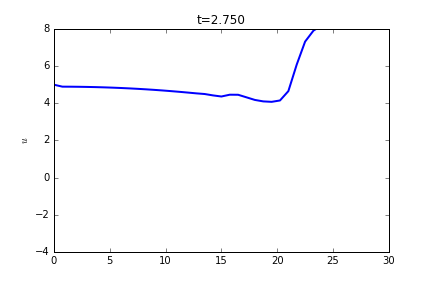
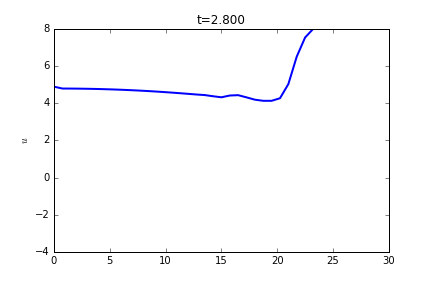
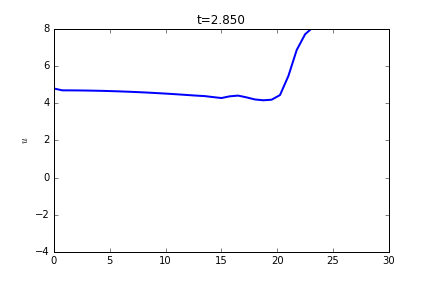
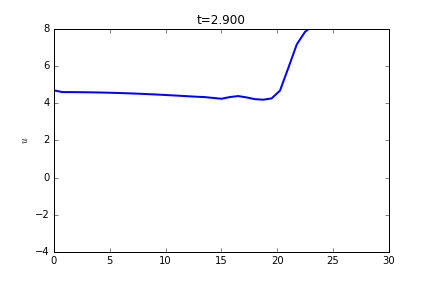
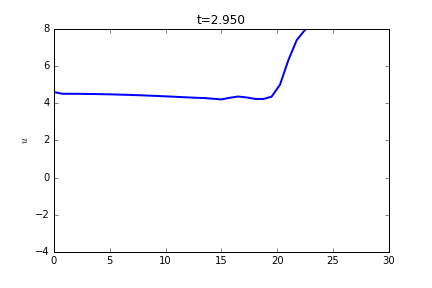
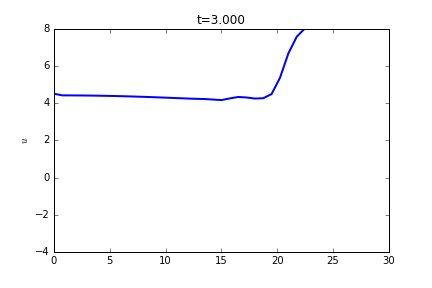
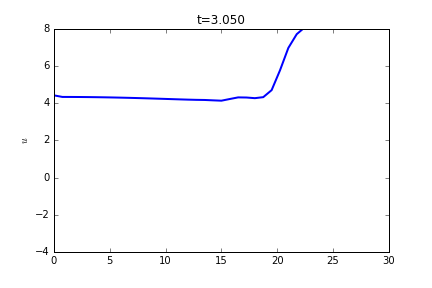
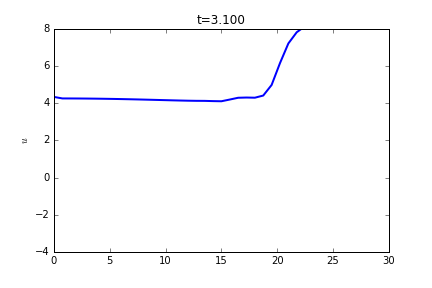
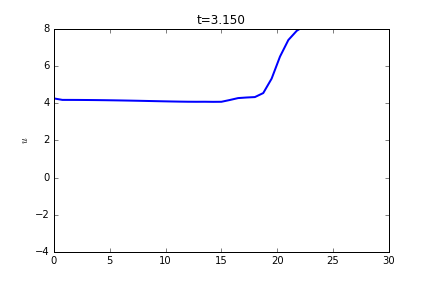
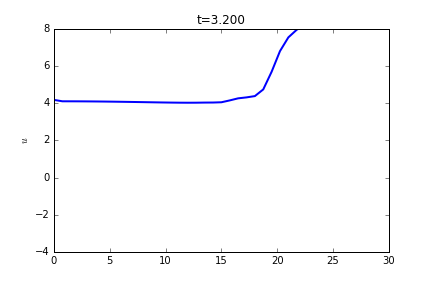
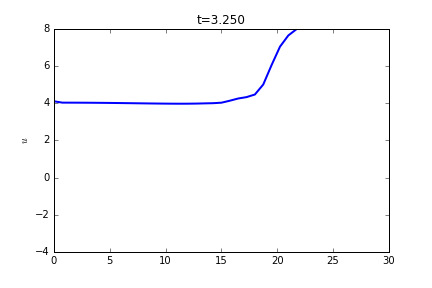
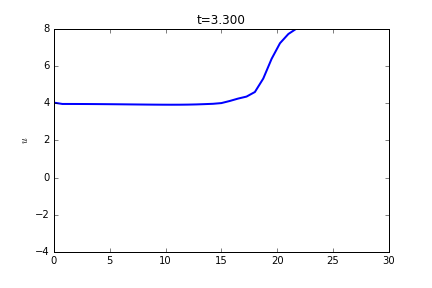
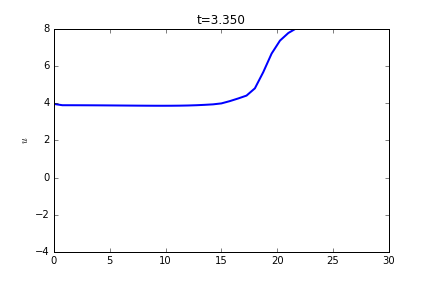
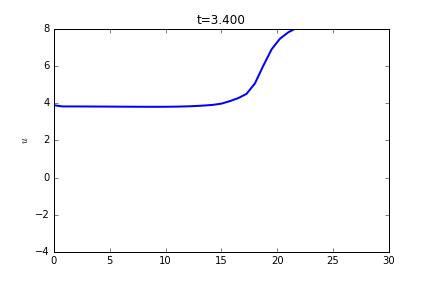
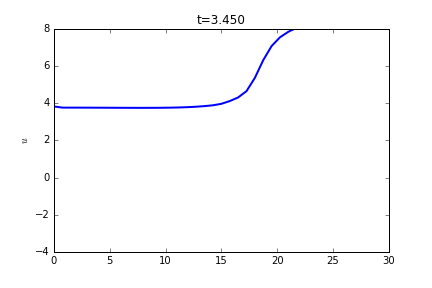
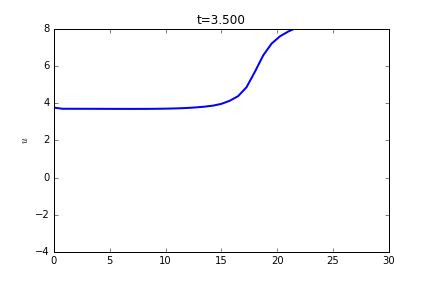
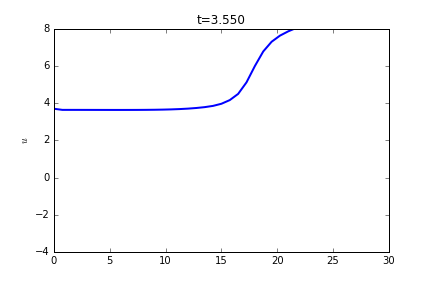
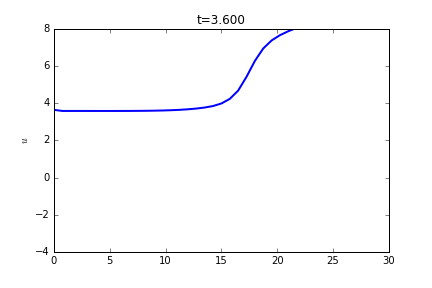
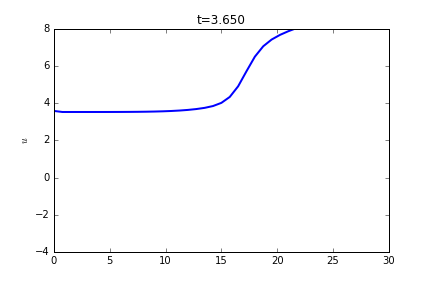
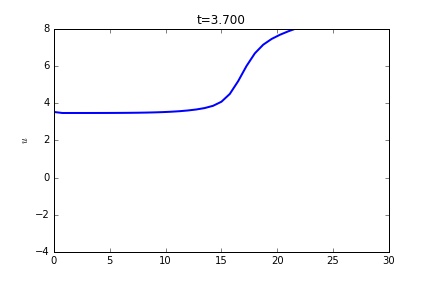
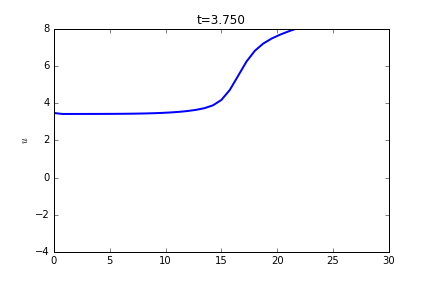
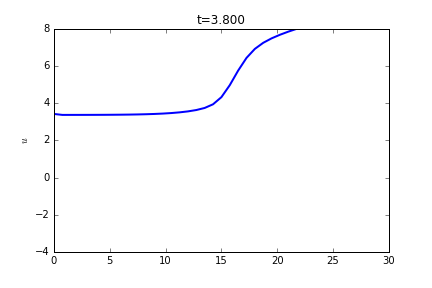
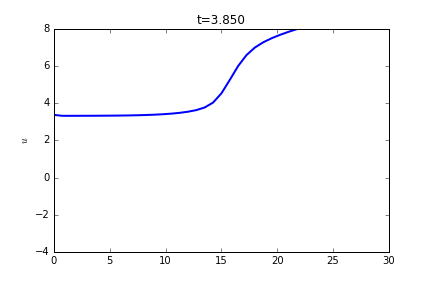
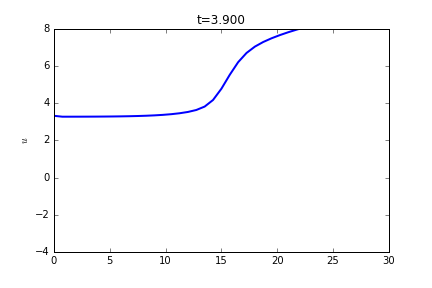
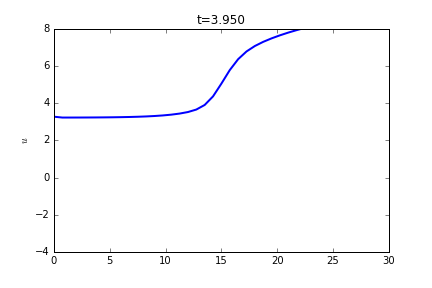
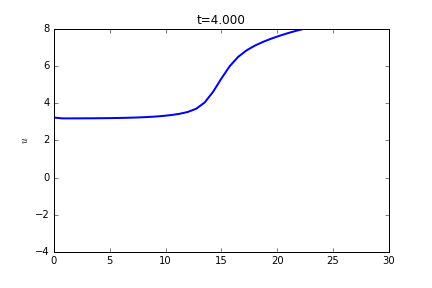
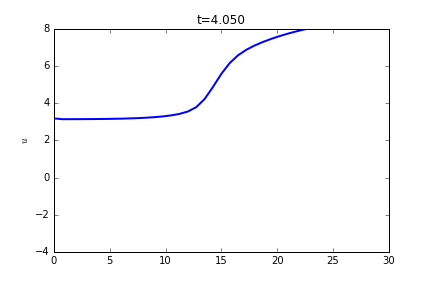
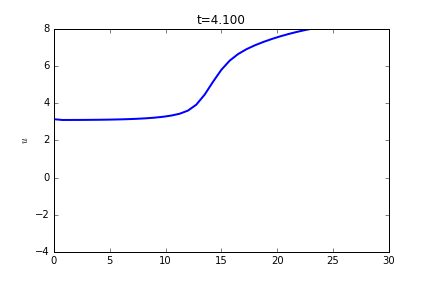
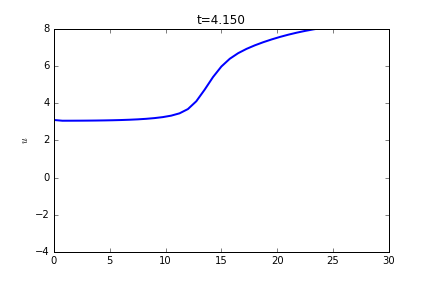
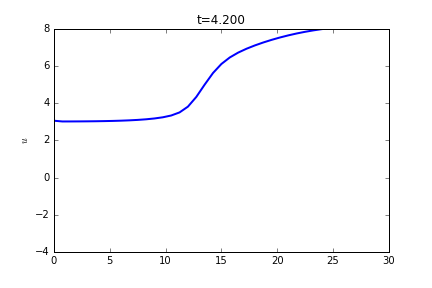
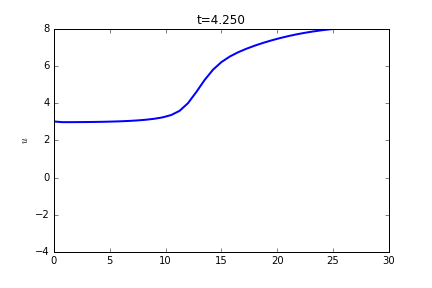
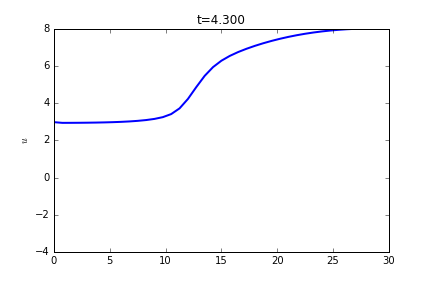
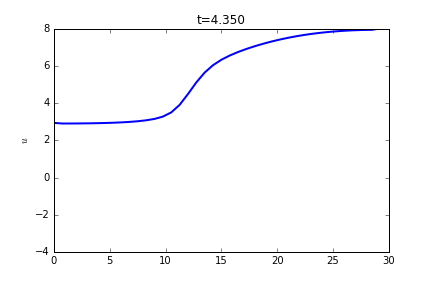
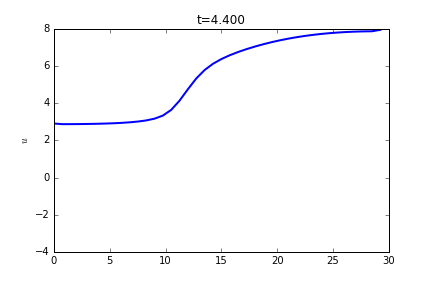
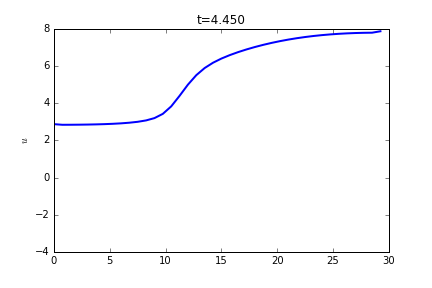
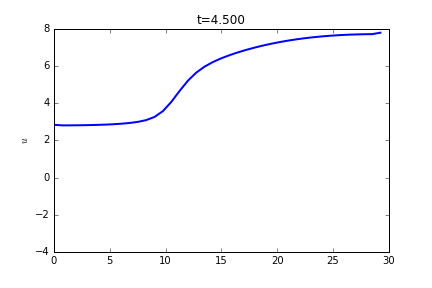
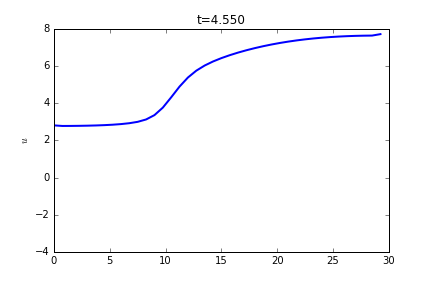
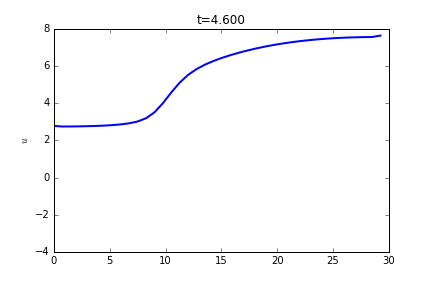
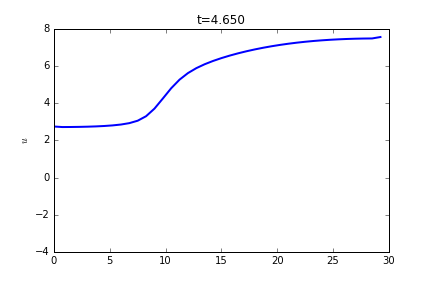
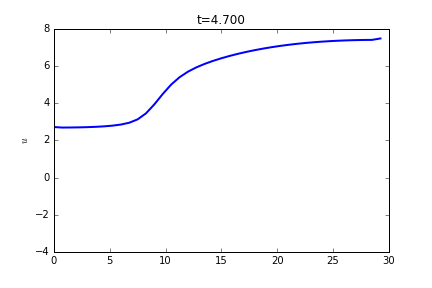
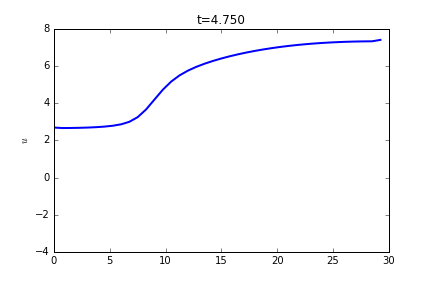
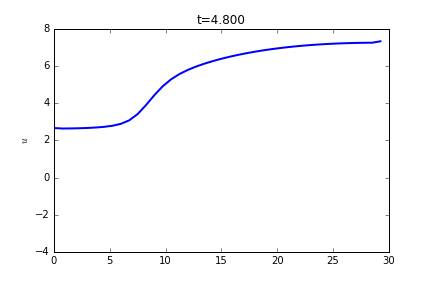
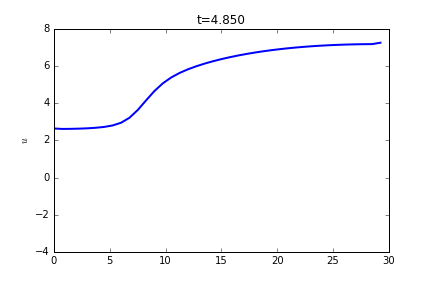
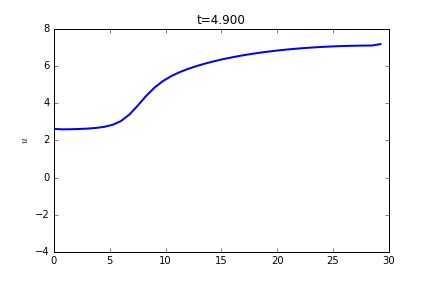
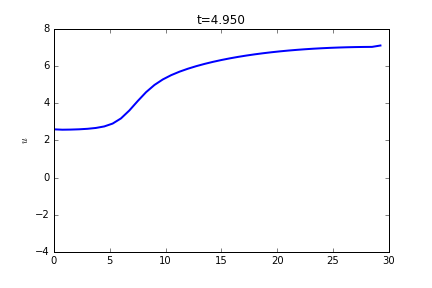
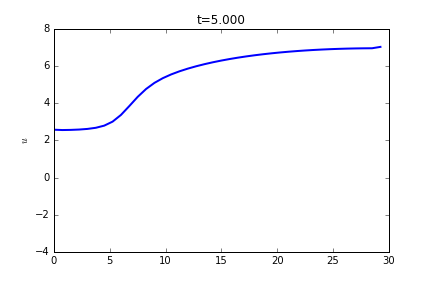
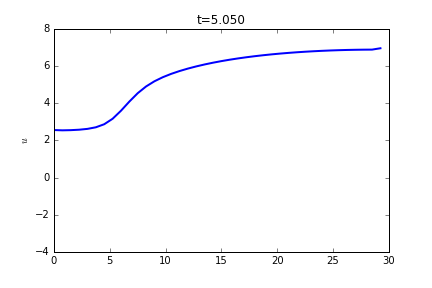
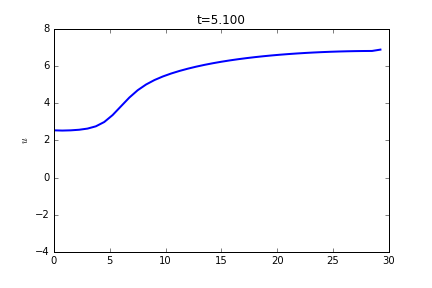
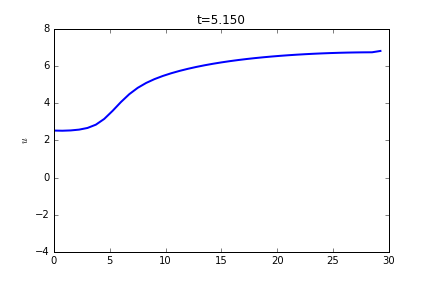
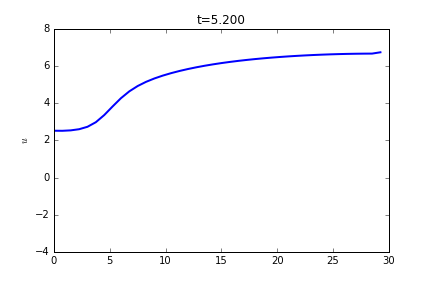
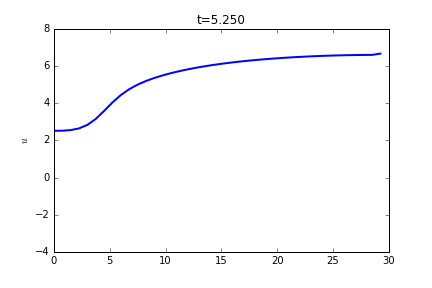
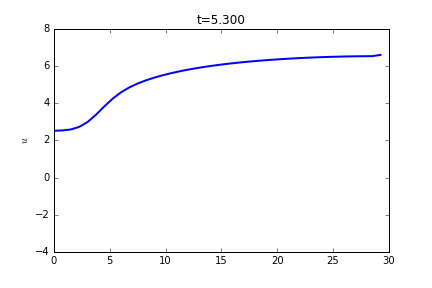
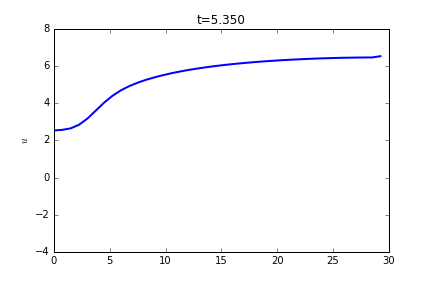
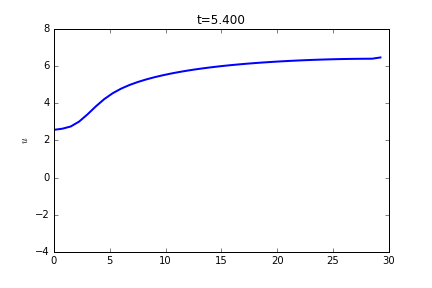
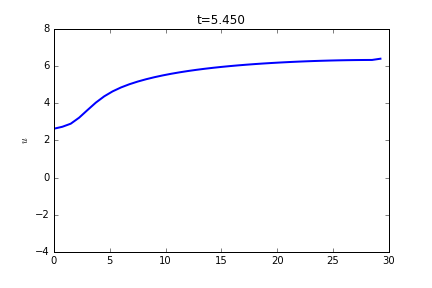
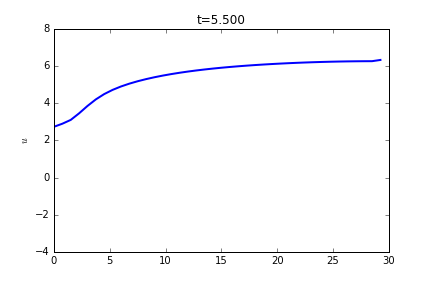
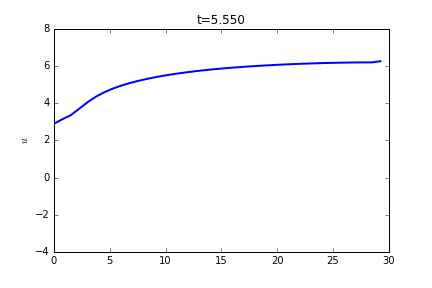
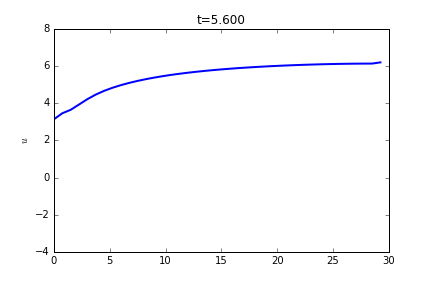
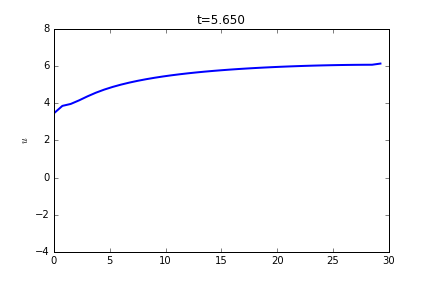
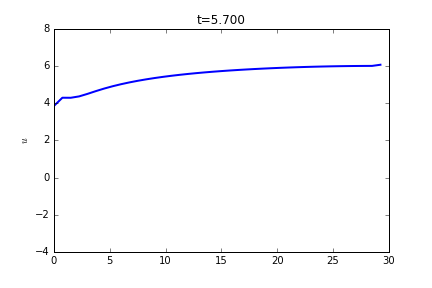
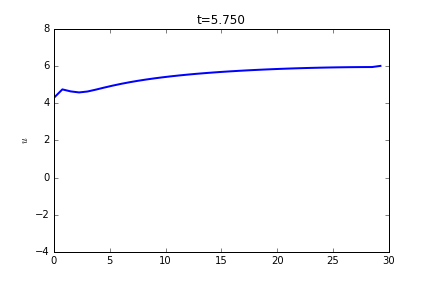
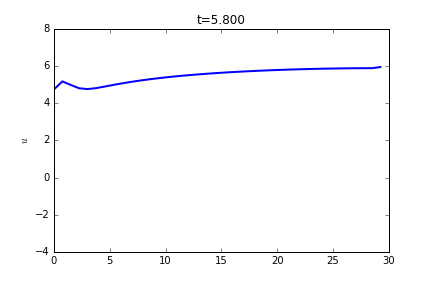
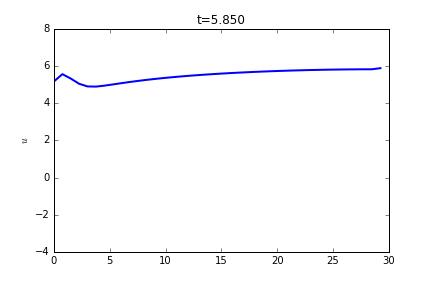
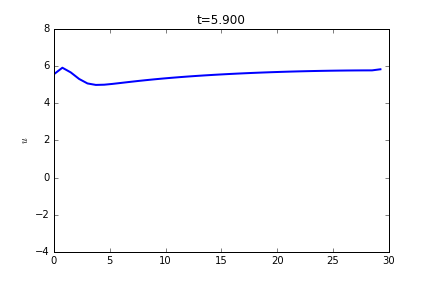
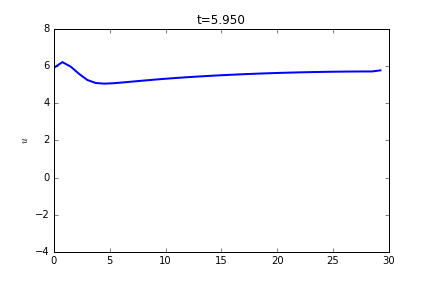
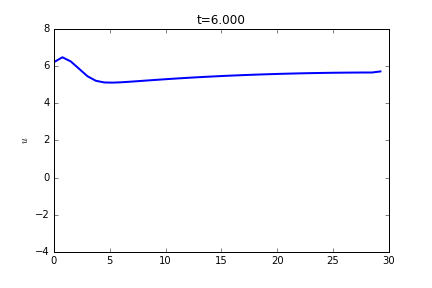
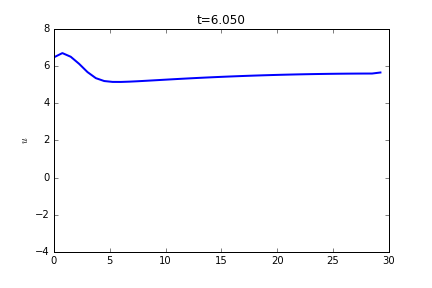
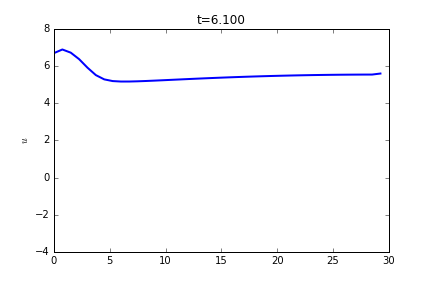
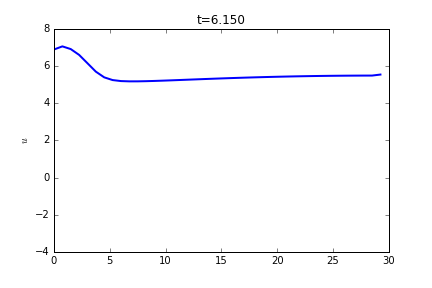
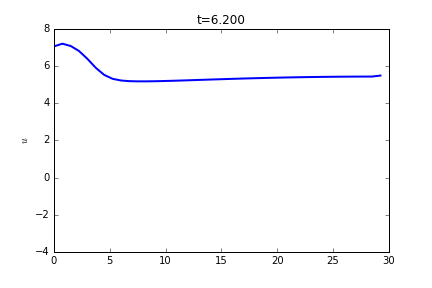
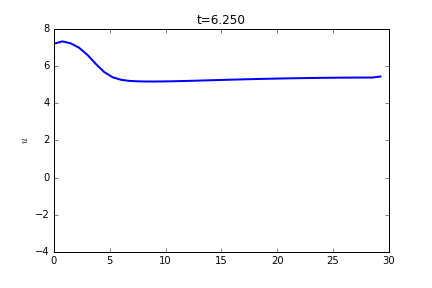
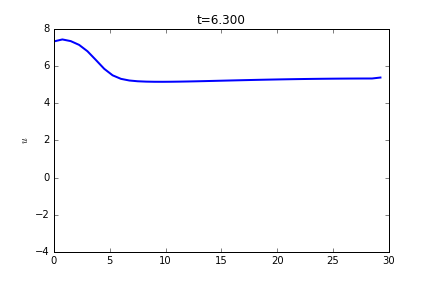
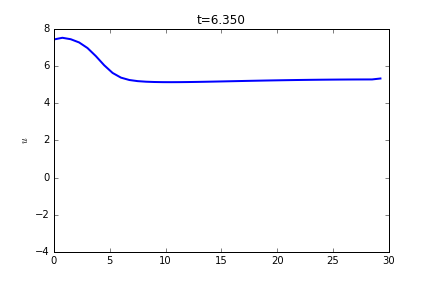
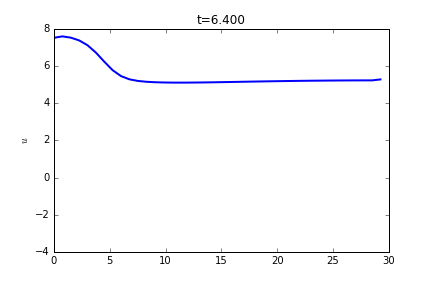
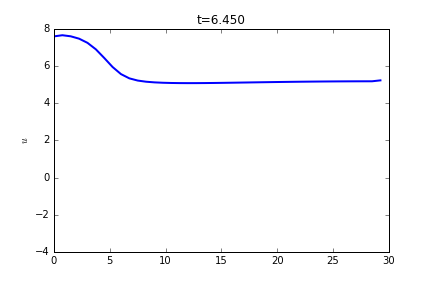
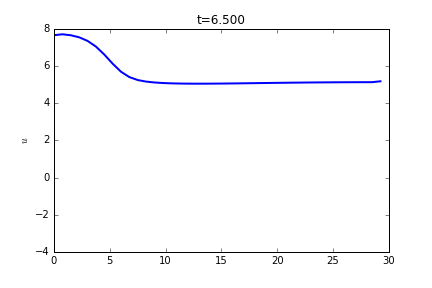
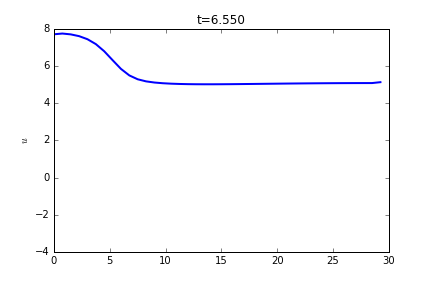
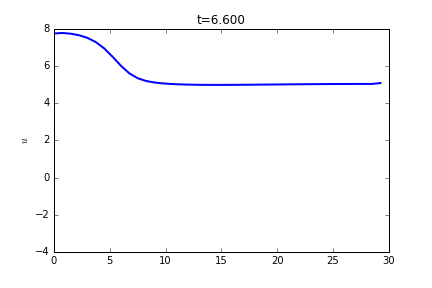
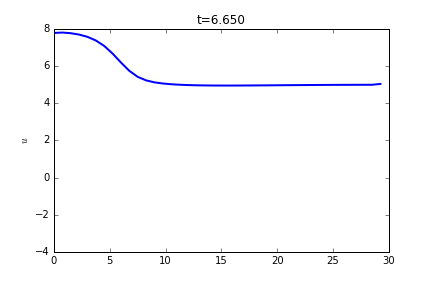
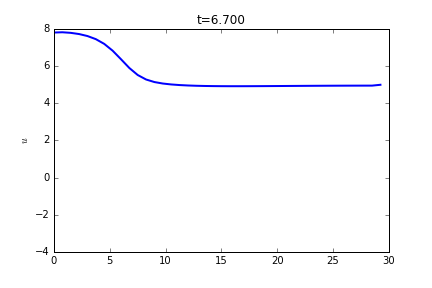
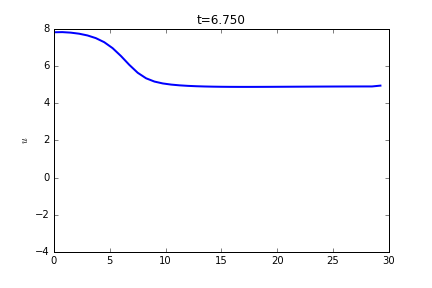
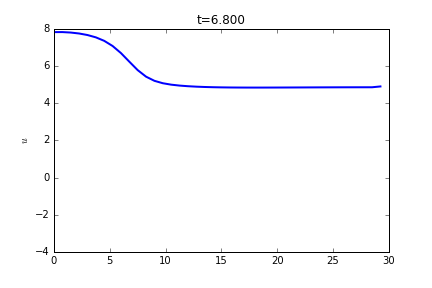
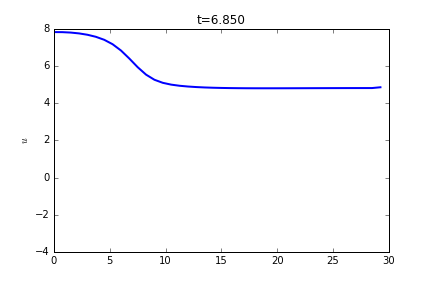
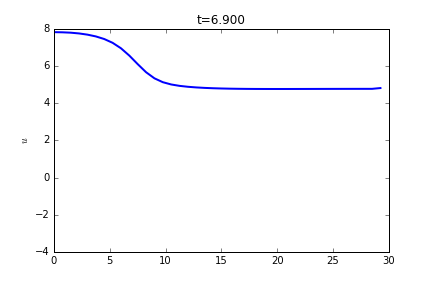
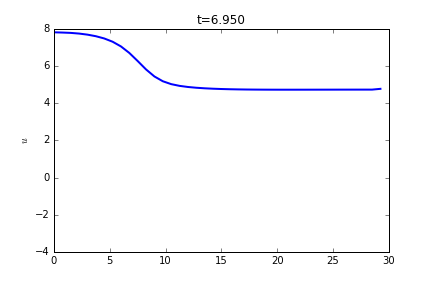
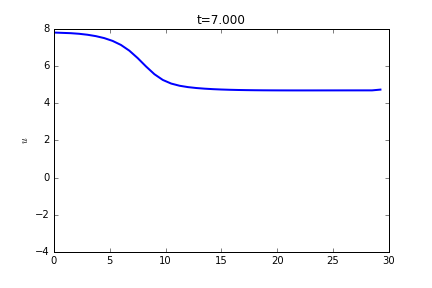
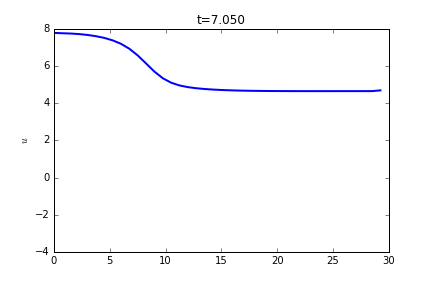
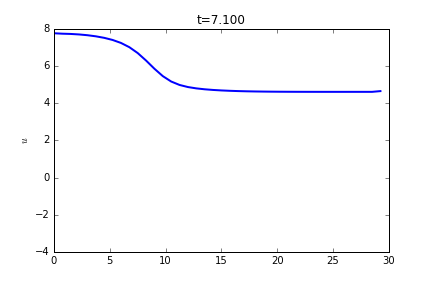
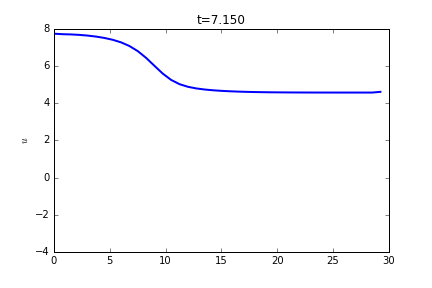
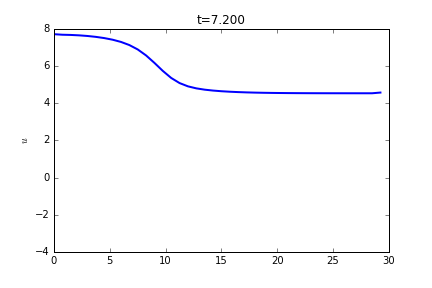
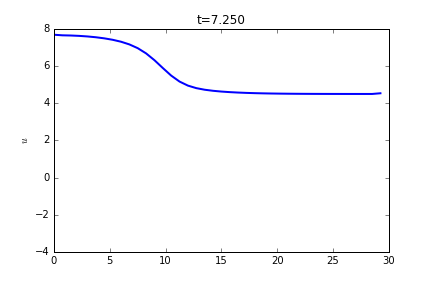
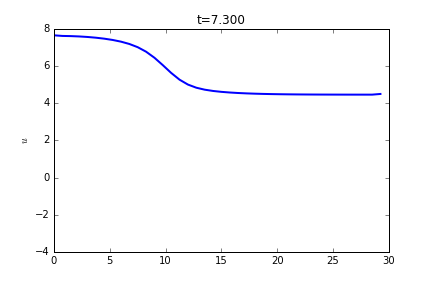
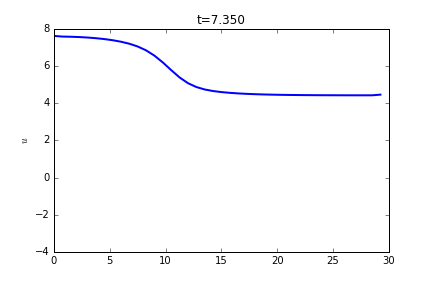
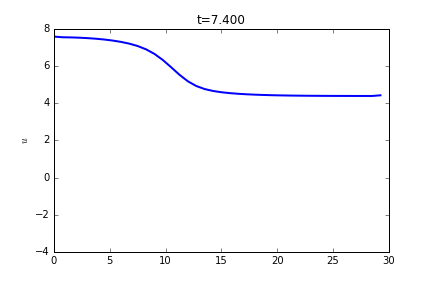
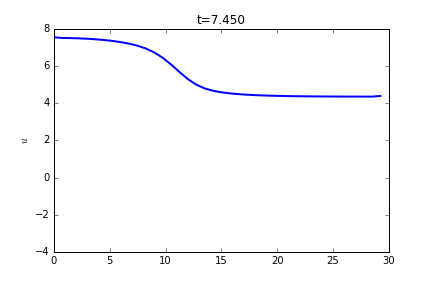
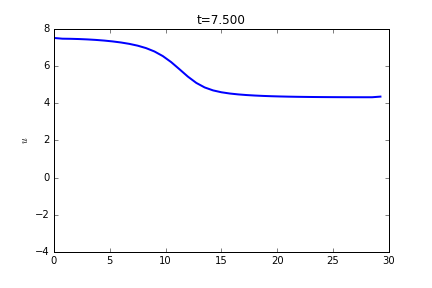
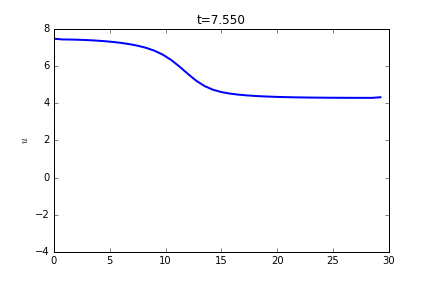
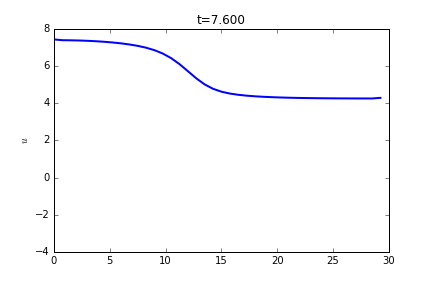
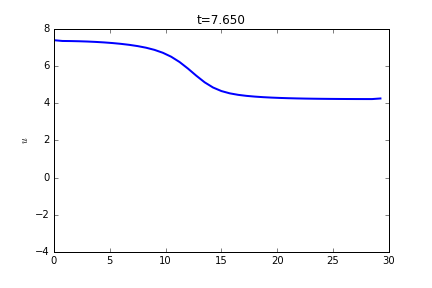
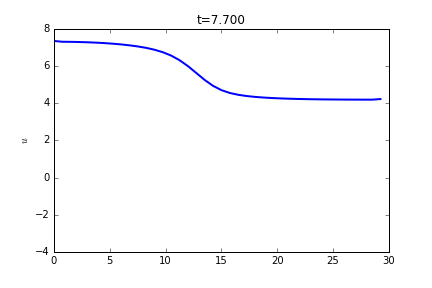
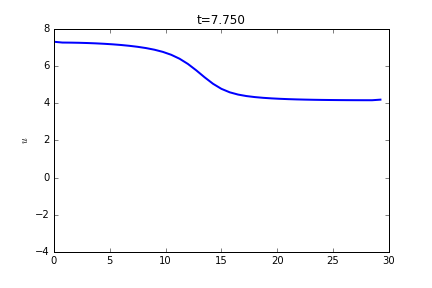
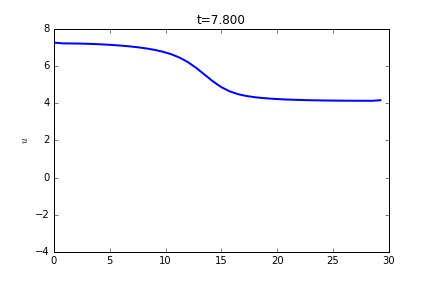
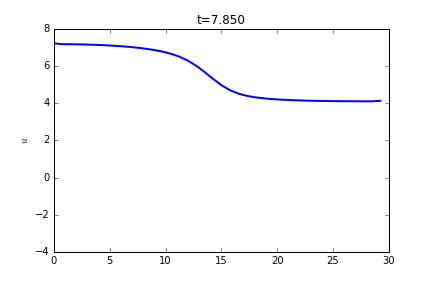
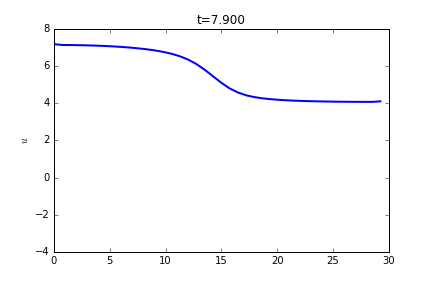
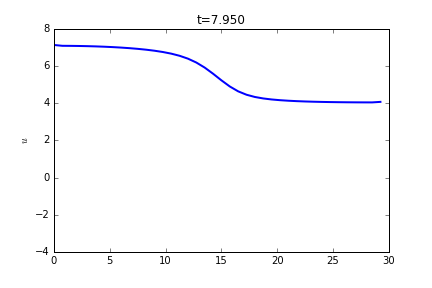
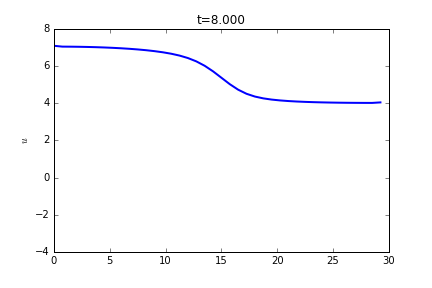
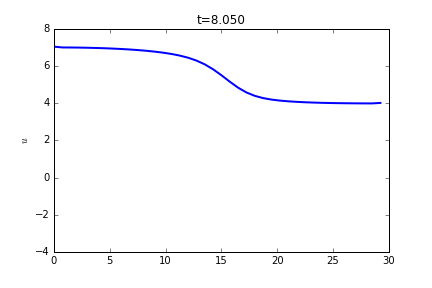
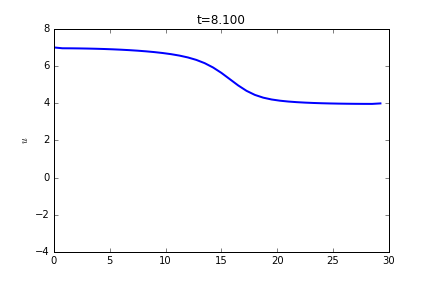
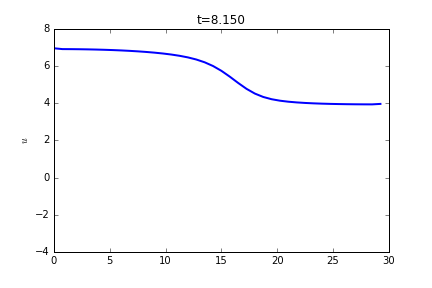
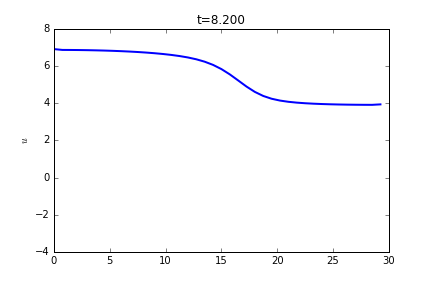
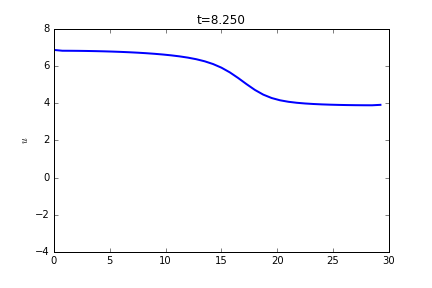
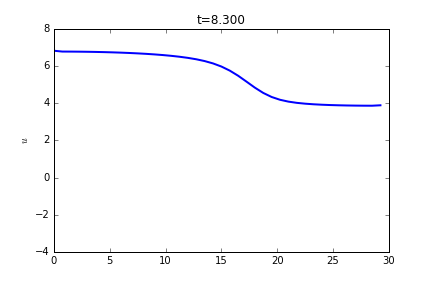
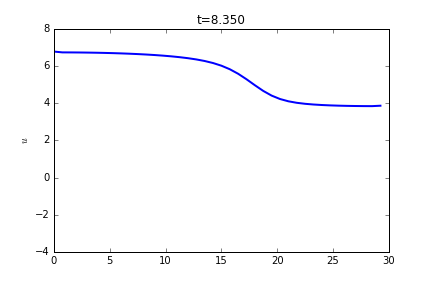
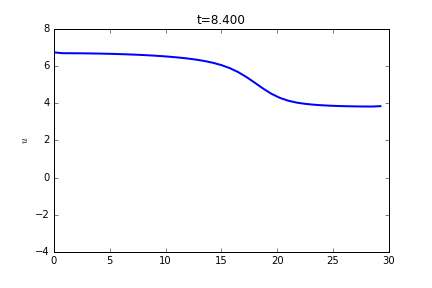
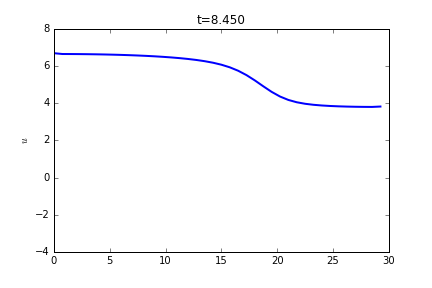
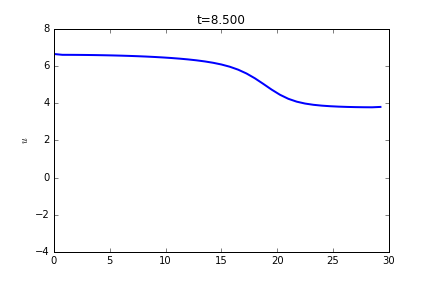
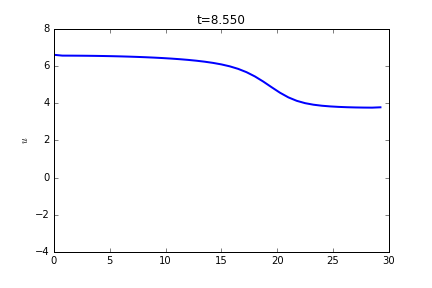
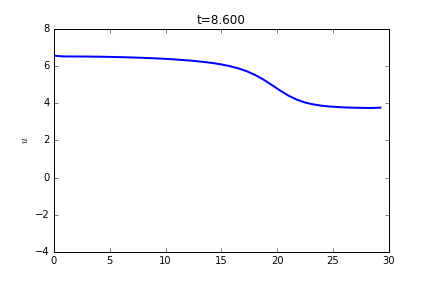
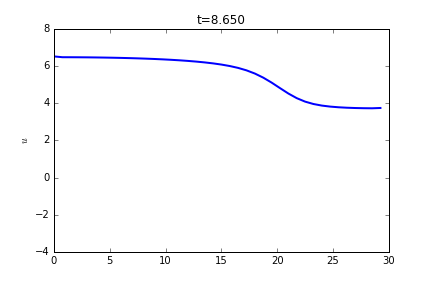
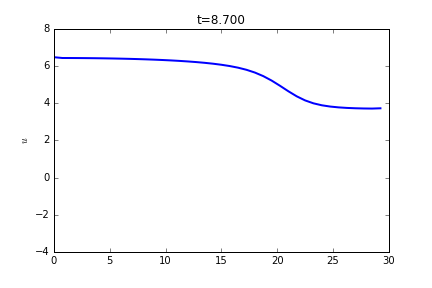
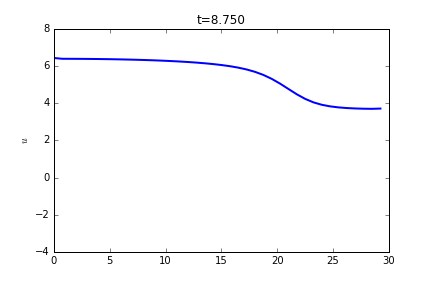
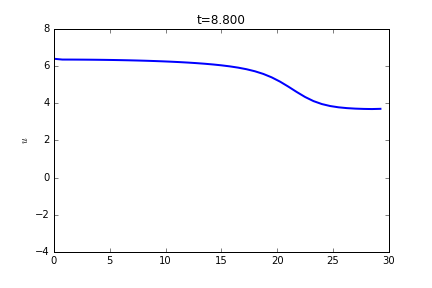
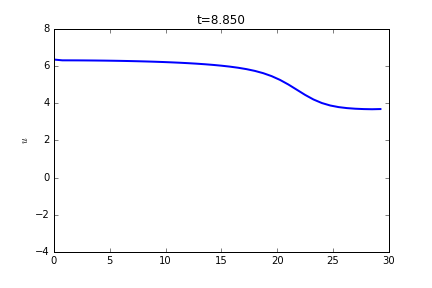
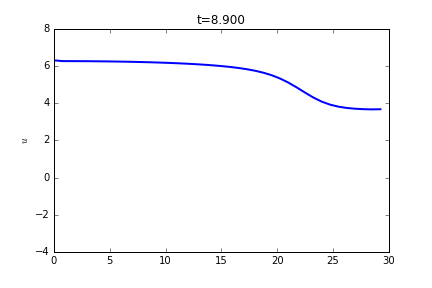
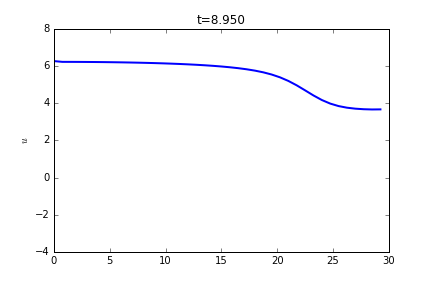
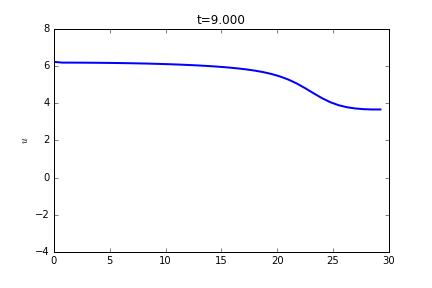
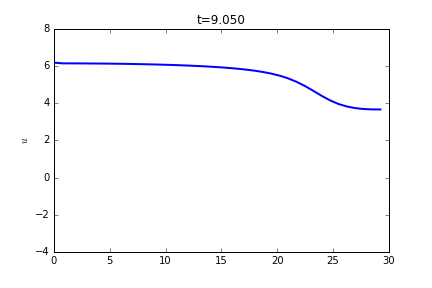
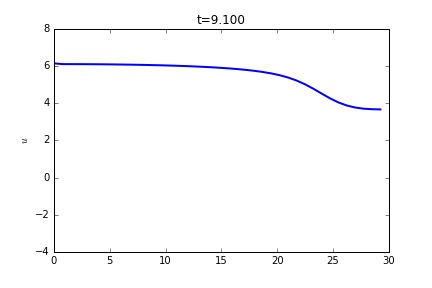
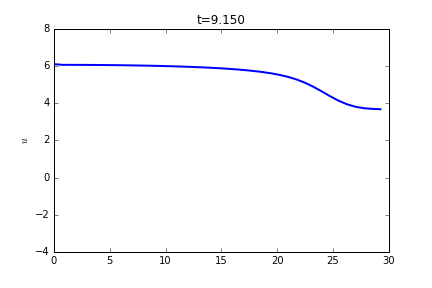
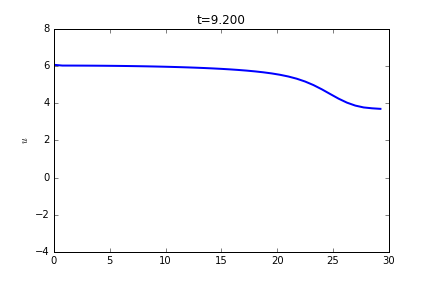
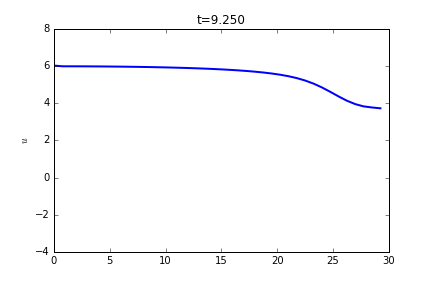
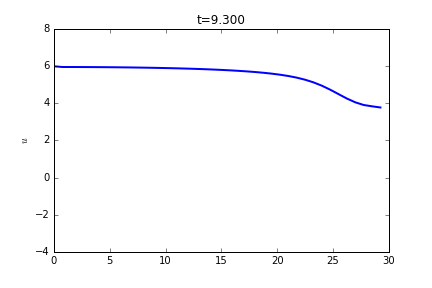
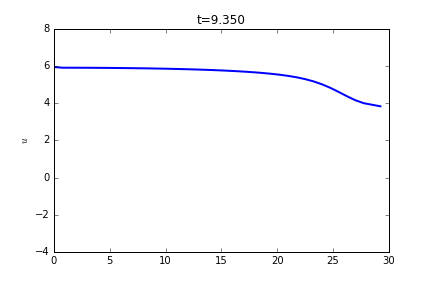
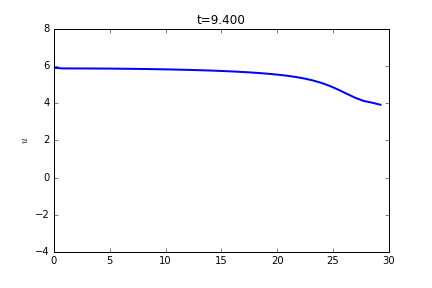
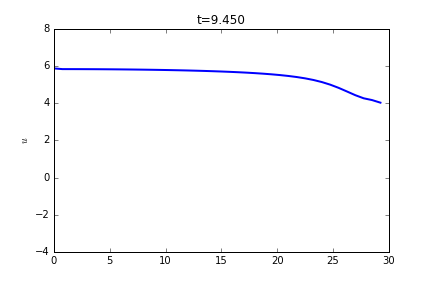
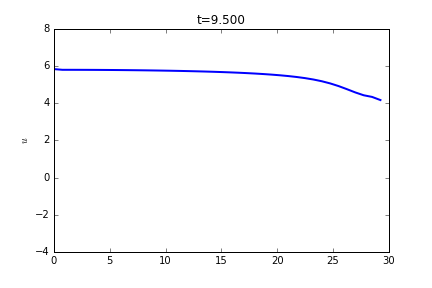
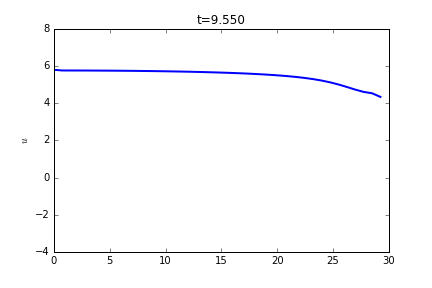
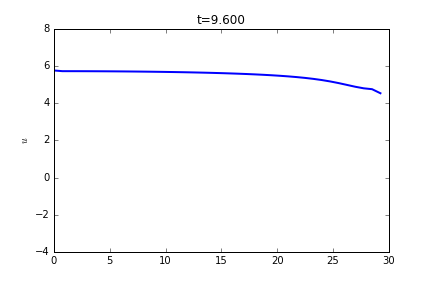
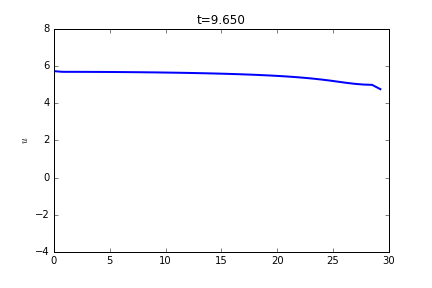
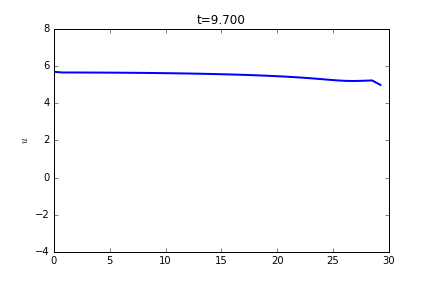
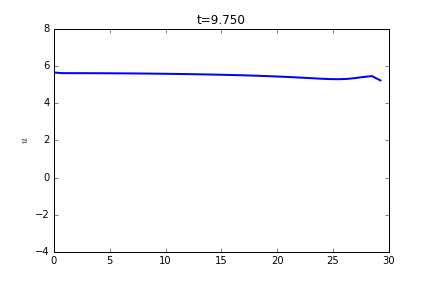
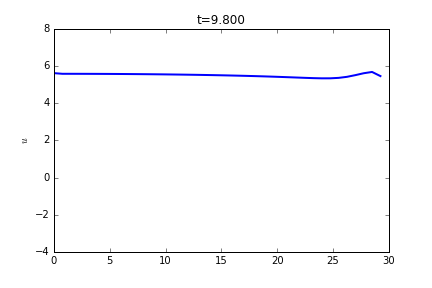
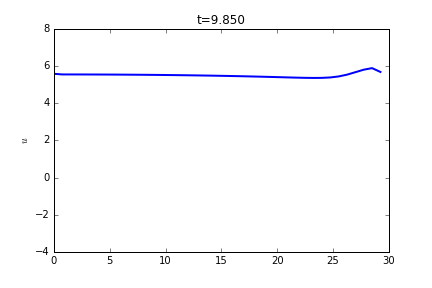
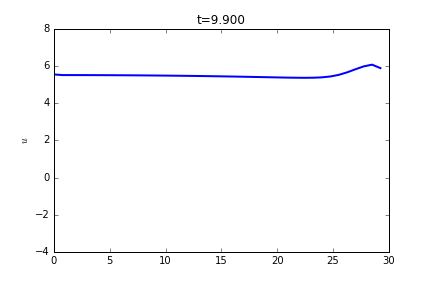
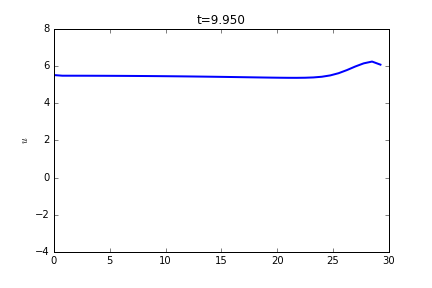
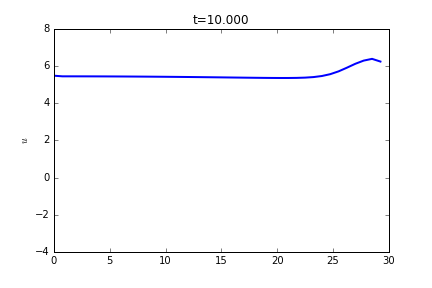

In [10]:
gF.plotAnimation(x,hall,tall,xmin,xmax,-4,8)